# EAS: Colectores

En este notebook se presenta el entrenamiento de un modelo para detectar y segmentar colectores solares, y clasificarlos según el tipo de equipo. En este prototipo se entrenó un modelo con un GeoJSON de anotaciones de colectores, clasificados en 4 tipos, más un adicional "NA" que corresponde a colectores que no tienen un tipo definido (por falta de información):

* Plano (`PL`)
* Plano sin Cubierta (`PS`)
* Plano con Cubierta (`PC`)
* Tubos de Vacío (`TV`)
* N/A (`NA`)

Al shapefile original de anotaciones se le agregó una columna `class`, con esos nombres, para facilitar el uso de las herramientas de generación de máscaras.

## Preparación de datos

Dado que las anotaciones fueron hechas sobre la cobertura urbana, se entrenará un sólo modelo a partir de la ortoimagen urbana. Aprovechando que `ideuy` nos permite descargar sólo las imágenes que necesitamos para el entrenamiento, utilizaremos el mismo GeoJSON de anotaciones para filtrar la grilla urbana y descargar sólo esas hojas.

El archivo vectorial de anotaciones se encuentra en `data/colectores/shp/` y es:

* `colectores_urb_pol.geojson`: Colectores en cobertura urbana

In [1]:
DATA_DIR = "data/colectores"

In [2]:
!ls $DATA_DIR/shp

colectores_urb_pol.geojson


In [3]:
# Instalamos ideuy
!pip install -U ideuy

Requirement already up-to-date: ideuy in /home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages (0.1.0)


In [4]:
# Reproyectamos a epsg:5381 (requerimiento de ideuy_filter)
!ogr2ogr -f GeoJSON -t_srs epsg:5381 /tmp/colectores_urb_pol_5381.geojson $DATA_DIR/shp/colectores_urb_pol.geojson 

In [5]:
# Generamos la grilla filtrada para urbano
!ideuy_filter -t urban \
              -o /tmp/colectores_urb_grilla.geojson \
              -v \
              /tmp/colectores_urb_pol_5381.geojson

In [6]:
# Descargamos las hojas de la imagen urbana
!ideuy_download \
    -t urban \
    -p rgb_8bit \
    -j4 \
    -v \
    -o $DATA_DIR/train/raw_images \
    /tmp/colectores_urb_grilla.geojson

  0%|                                                    | 0/76 [00:00<?, ?it/s][2020-10-22 15:10:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_04/02_Ortoimagenes/04_Ciudad_LPS/03_RGB_8bits/K29B2N9_RGB_8_Remesa_04_LPS.jpg to data/colectores/train/raw_images
[2020-10-22 15:10:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5N6_RGB_8_Remesa_01_MVD.jpg to data/colectores/train/raw_images
[2020-10-22 15:10:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B6M4_RGB_8_Remesa_01_MVD.jpg to data/colectores/train/raw_images
[2020-10-22 15:10:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29D2M7_RGB_8_Remesa_01_MVD.jpg to data/colectores/train/raw_images

K29B2N9_RGB_8_Remesa_04_LPS.jpg:   0%|     

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 13.5M/77.8M [00:07<00:34, 1.87MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  18%|▉    | 13.8M/77.8M [00:07<00:32, 1.95MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  16%|▊    | 11.7M/73.2M [00:07<00:36, 1.68MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  13%|▋    | 9.17M/70.3M [00:07<00:54, 1.12MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 6.54M/71.3M [00:07<01:05, 984kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:   9%|▍    | 6.71M/71.3M [00:07<01:02, 1.03MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  18%|▉    | 14.2M/77.8M [00:07<00:29, 2.13MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  16%|▊    | 11.9M/73.2M [00:07<00:40, 1.50MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  13%|▊     | 9.29M/70.3M [00:07<01:01, 989kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.2M/73.2M [00:07<00:37, 1.61MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  10%|▍    | 6.89M/71.3M [00:07<00:59, 1.08MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  19%|▉    | 14.6M/77.8M [00:07<00:28, 2.25MB/s]
K29B2N9_RG

K29D2M7_RGB_8_Remesa_01_MVD.jpg:  16%|▉     | 11.7M/71.3M [00:14<01:56, 512kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.6M/73.2M [00:14<00:52, 1.00MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  19%|█▏    | 13.4M/70.3M [00:14<02:46, 341kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  31%|█▌   | 24.4M/77.8M [00:14<00:51, 1.04MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  16%|▉     | 11.7M/71.3M [00:14<01:56, 512kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.8M/73.2M [00:14<00:51, 1.02MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  19%|█▏    | 13.4M/70.3M [00:14<02:47, 339kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  31%|█▉    | 24.5M/77.8M [00:14<01:05, 811kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  29%|█▍   | 20.9M/73.2M [00:14<00:50, 1.04MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  19%|█▏    | 13.5M/70.3M [00:14<02:31, 375kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  17%|▉     | 11.8M/71.3M [00:14<01:57, 506kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  32%|█▉    | 24.7M/77.8M [00:14<00:56, 949kB/s]


K29B6M4_RGB

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  35%|██    | 27.4M/77.8M [00:17<00:54, 918kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  35%|██▏   | 27.6M/77.8M [00:17<00:50, 998kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 24.1M/73.2M [00:17<00:47, 1.04MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  21%|█▎    | 14.7M/70.3M [00:17<01:57, 473kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.5M/71.3M [00:17<01:43, 556kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.6M/71.3M [00:17<01:37, 590kB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  21%|█▎    | 14.8M/70.3M [00:17<01:50, 500kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 27.7M/77.8M [00:17<00:48, 1.02MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 24.3M/73.2M [00:17<00:44, 1.09MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.7M/71.3M [00:17<01:29, 643kB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  21%|█▎    | 14.9M/70.3M [00:17<01:48, 510kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 27.9M/77.8M [00:17<00:44, 1.12MB/s]


K29B6M4_RG

K29B6M4_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.8M/73.2M [00:20<00:37, 1.22MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.9M/73.2M [00:20<00:35, 1.26MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  23%|█▎    | 16.1M/71.3M [00:20<01:00, 919kB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  24%|█▍    | 17.1M/70.3M [00:20<00:59, 890kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  40%|██   | 31.4M/77.8M [00:20<00:37, 1.25MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  41%|██   | 31.6M/77.8M [00:20<00:36, 1.25MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  25%|█▍    | 17.2M/70.3M [00:20<00:55, 957kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  23%|█▏   | 16.4M/71.3M [00:20<00:52, 1.04MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 28.2M/73.2M [00:20<00:33, 1.35MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  41%|██   | 31.8M/77.8M [00:20<00:33, 1.37MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  25%|█▏   | 17.4M/70.3M [00:20<00:49, 1.06MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  23%|█▏   | 16.5M/71.3M [00:20<00:51, 1.07MB/s]


K29B6M4_RG

K29B2N9_RGB_8_Remesa_04_LPS.jpg:  38%|██▎   | 26.8M/70.3M [00:27<00:50, 868kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  37%|██▏   | 26.4M/71.3M [00:27<00:52, 849kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  55%|██▊  | 43.1M/77.8M [00:27<00:27, 1.27MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  38%|██▎   | 26.9M/70.3M [00:27<00:51, 838kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  52%|██▌  | 38.0M/73.2M [00:27<00:22, 1.53MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 43.3M/77.8M [00:27<00:30, 1.13MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  38%|██▎   | 27.0M/70.3M [00:27<00:51, 847kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  37%|██▏   | 26.5M/71.3M [00:27<00:51, 869kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  52%|██▌  | 38.2M/73.2M [00:27<00:26, 1.33MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 43.5M/77.8M [00:27<00:28, 1.20MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  39%|██▎   | 27.1M/70.3M [00:27<00:57, 757kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  52%|██▌  | 38.4M/73.2M [00:27<00:26, 1.33MB/s]



K29D2M7_RG

K29B6M4_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 42.6M/73.2M [00:30<00:25, 1.21MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  42%|██▌   | 29.8M/70.3M [00:30<00:49, 816kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 42.8M/73.2M [00:30<00:23, 1.28MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  41%|██▍   | 29.3M/71.3M [00:30<00:46, 901kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  60%|███  | 47.0M/77.8M [00:30<00:30, 1.00MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  61%|███  | 47.2M/77.8M [00:30<00:28, 1.07MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  43%|██▌   | 30.0M/70.3M [00:30<00:49, 810kB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  41%|██▍   | 29.5M/71.3M [00:30<00:44, 934kB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 43.1M/73.2M [00:30<00:21, 1.40MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 43.3M/73.2M [00:30<00:20, 1.47MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  43%|██▌   | 30.1M/70.3M [00:30<00:46, 871kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  61%|███  | 47.3M/77.8M [00:30<00:29, 1.02MB/s]



K29D2M7_RG

K29B2N9_RGB_8_Remesa_04_LPS.jpg:  47%|██▎  | 33.2M/70.3M [00:33<00:29, 1.26MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  46%|██▎  | 32.8M/71.3M [00:33<00:32, 1.19MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  66%|███▎ | 48.6M/73.2M [00:33<00:12, 1.92MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  66%|███▎ | 51.7M/77.8M [00:33<00:18, 1.42MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  48%|██▍  | 33.4M/70.3M [00:33<00:27, 1.32MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 51.9M/77.8M [00:33<00:17, 1.46MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  46%|██▎  | 33.0M/71.3M [00:33<00:31, 1.21MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 48.8M/73.2M [00:33<00:14, 1.67MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  48%|██▍  | 33.5M/70.3M [00:34<00:30, 1.22MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 52.1M/77.8M [00:33<00:16, 1.55MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  47%|██▎  | 33.2M/71.3M [00:33<00:28, 1.32MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 49.1M/73.2M [00:33<00:12, 1.85MB/s]
K29B2N9_RG

K29D2M7_RGB_8_Remesa_01_MVD.jpg:  52%|██▌  | 37.1M/71.3M [00:36<00:18, 1.86MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  54%|██▋  | 37.7M/70.3M [00:36<00:19, 1.68MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 55.7M/73.2M [00:36<00:06, 2.83MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  52%|██▌  | 37.4M/71.3M [00:36<00:17, 1.94MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 56.0M/77.8M [00:36<00:14, 1.54MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  54%|██▋  | 38.0M/70.3M [00:36<00:16, 1.90MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  53%|██▋  | 37.7M/71.3M [00:36<00:15, 2.17MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 56.0M/73.2M [00:36<00:06, 2.79MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 56.1M/77.8M [00:36<00:13, 1.61MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  54%|██▋  | 38.2M/70.3M [00:36<00:17, 1.84MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  77%|███▊ | 56.4M/73.2M [00:36<00:05, 3.11MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  53%|██▋  | 37.9M/71.3M [00:36<00:17, 1.87MB/s]

K29B5N6_RG

K29D2M7_RGB_8_Remesa_01_MVD.jpg:  64%|███▏ | 45.5M/71.3M [00:39<00:10, 2.49MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  65%|███▏ | 45.4M/70.3M [00:39<00:10, 2.45MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 60.6M/77.8M [00:39<00:11, 1.49MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 67.3M/73.2M [00:39<00:01, 3.65MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  64%|███▏ | 45.9M/71.3M [00:39<00:09, 2.72MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 60.8M/77.8M [00:39<00:11, 1.48MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  65%|███▎ | 45.9M/70.3M [00:39<00:09, 2.50MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 67.6M/73.2M [00:39<00:01, 3.66MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  65%|███▏ | 46.3M/71.3M [00:39<00:08, 3.00MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 61.0M/77.8M [00:39<00:10, 1.53MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  66%|███▎ | 46.4M/70.3M [00:40<00:09, 2.57MB/s]


K29B6M4_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 68.0M/73.2M [00:39<00:01, 3.14MB/s]

K29B5N6_RGB_

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  89%|████▍| 69.2M/77.8M [00:46<00:07, 1.13MB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  87%|████▎| 60.9M/70.3M [00:46<00:03, 2.50MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 61.1M/71.3M [00:46<00:05, 1.82MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:   1%|     | 1.08M/74.1M [00:02<18:50, 64.6kB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  87%|████▎| 61.2M/70.3M [00:46<00:03, 2.39MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 61.4M/71.3M [00:46<00:04, 2.09MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  89%|████▍| 69.3M/77.8M [00:46<00:08, 1.02MB/s]



K29D2M7_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 61.6M/71.3M [00:46<00:04, 2.10MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  89%|████▍| 69.4M/77.8M [00:46<00:08, 1.00MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:   2%|     | 1.25M/74.1M [00:02<13:31, 89.8kB/s]
K29B2N9_RGB_8_Remesa_04_LPS.jpg:  87%|████▎| 61.4M/70.3M [00:46<00:04, 2.08MB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jpg:  89%|████▍| 69.5M/77.8M [00:46<00:07, 1.06MB/s]
K29B2N9_RGB_




K29D2N8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 9.32M/74.1M [00:09<00:52, 1.24MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:   0%|   | 41.0k/71.3M [00:01<6:46:59, 2.92kB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:   0%|   | 98.3k/71.3M [00:01<4:45:42, 4.15kB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 9.54M/74.1M [00:09<00:51, 1.26MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:   0%|  | 1.02k/72.4M [00:00<14:13:15, 1.41kB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:   0%|    | 206k/71.3M [00:01<3:20:14, 5.92kB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 9.77M/74.1M [00:09<00:50, 1.27MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:   0%|  | 9.22k/72.4M [00:00<10:04:45, 2.00kB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:   1%|    | 427k/71.3M [00:01<2:20:00, 8.43kB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 9.99M/74.1M [00:10<00:50, 1.28MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:   0%|   | 38.9k/72.4M [00:01<7:05:14, 2.84kB/s]

K29B5N6_RGB_8_Remesa_01_MVD.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]
K29D3M1_R

K29D3M3_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.2M/72.4M [00:07<00:44, 1.35MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  23%|█▏   | 16.6M/71.3M [00:08<00:25, 2.11MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  24%|█▏   | 16.8M/71.3M [00:08<00:27, 1.99MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.3M/72.4M [00:08<00:57, 1.04MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.4M/74.1M [00:17<00:51, 1.04MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:   9%|▍    | 6.14M/72.2M [00:05<00:53, 1.24MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.7M/74.1M [00:17<00:42, 1.26MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.5M/72.4M [00:08<00:51, 1.17MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:   9%|▍    | 6.59M/72.2M [00:05<00:41, 1.59MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  24%|█▏   | 17.1M/71.3M [00:08<00:26, 2.04MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.7M/72.4M [00:08<00:53, 1.11MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.8M/74.1M [00:17<00:46, 1.15MB/s]

K29D3M5_RG

K29D2N8_RGB_8_Remesa_01_MVD.jpg:  32%|█▌   | 24.0M/74.1M [00:20<00:38, 1.29MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  21%|█    | 15.4M/72.4M [00:11<00:52, 1.09MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 23.2M/71.3M [00:11<00:21, 2.19MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.1M/72.2M [00:08<00:28, 2.08MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 24.1M/74.1M [00:20<00:45, 1.11MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 23.4M/71.3M [00:11<00:22, 2.14MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  21%|█    | 15.5M/72.4M [00:11<00:56, 1.02MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 12.3M/72.2M [00:08<00:30, 1.95MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 23.7M/71.3M [00:11<00:20, 2.27MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  33%|█▋   | 24.3M/74.1M [00:20<00:41, 1.20MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  22%|█    | 15.6M/72.4M [00:11<00:55, 1.02MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  18%|▉    | 12.7M/72.2M [00:08<00:27, 2.13MB/s]
K29D3M1_RGB_

K29D3M3_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.5M/72.4M [00:13<00:53, 1.01MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 27.5M/74.1M [00:23<00:42, 1.10MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  40%|██   | 28.6M/71.3M [00:14<00:28, 1.52MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.4M/72.2M [00:11<00:30, 1.77MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.7M/72.4M [00:14<00:49, 1.09MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 27.6M/74.1M [00:23<00:43, 1.08MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  40%|██   | 28.8M/71.3M [00:14<00:25, 1.64MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.8M/72.4M [00:14<00:50, 1.05MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.7M/72.2M [00:11<00:31, 1.71MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 27.8M/74.1M [00:23<00:42, 1.10MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  41%|██   | 29.0M/71.3M [00:14<00:26, 1.62MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.9M/72.4M [00:14<00:50, 1.06MB/s]


K29D2N8_R

K29D2N8_RGB_8_Remesa_01_MVD.jpg:  45%|██▎  | 33.6M/74.1M [00:28<00:36, 1.12MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  53%|██▋  | 37.8M/71.3M [00:20<00:25, 1.32MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  42%|██   | 30.6M/72.2M [00:17<00:17, 2.34MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.6M/72.4M [00:19<00:23, 1.92MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  45%|██▎  | 33.7M/74.1M [00:29<00:37, 1.09MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 30.8M/72.2M [00:17<00:18, 2.26MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  53%|██▋  | 38.0M/71.3M [00:20<00:28, 1.16MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  46%|██▋   | 33.8M/74.1M [00:29<00:44, 905kB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 31.1M/72.2M [00:17<00:19, 2.15MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.8M/72.4M [00:20<00:27, 1.60MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  54%|██▋  | 38.2M/71.3M [00:20<00:24, 1.34MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  46%|██▊   | 34.0M/74.1M [00:29<00:40, 980kB/s]



K29D3M3_RG

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  63%|███▏ | 45.2M/72.2M [00:23<00:09, 2.81MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 41.4M/74.1M [00:35<00:22, 1.45MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  65%|███▎ | 46.5M/71.3M [00:26<00:17, 1.44MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  63%|███▏ | 45.5M/72.2M [00:23<00:10, 2.49MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 41.0M/72.4M [00:26<00:13, 2.41MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 41.5M/74.1M [00:35<00:21, 1.50MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  65%|███▎ | 46.7M/71.3M [00:26<00:18, 1.36MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  64%|███▏ | 46.0M/72.2M [00:23<00:09, 2.83MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 41.5M/72.4M [00:26<00:12, 2.42MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 41.7M/74.1M [00:35<00:25, 1.29MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  64%|███▏ | 46.4M/72.2M [00:23<00:08, 3.01MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  66%|███▎ | 46.9M/71.3M [00:26<00:19, 1.24MB/s]


K29D2N8_RGB

K29D3M1_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 55.3M/71.3M [00:32<00:11, 1.34MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg:  99%|████▉| 71.7M/72.2M [00:29<00:00, 3.62MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 50.9M/74.1M [00:41<00:14, 1.55MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 55.5M/71.3M [00:32<00:12, 1.28MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 56.2M/72.4M [00:32<00:09, 1.74MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 51.2M/74.1M [00:41<00:13, 1.75MB/s]

K29D3M5_RGB_8_Remesa_01_MVD.jpg: 72.2MB [00:29, 2.43MB/s]                       
[2020-10-22 15:12:02] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29D3M5_RGB_8_Remesa_01_MVD.jgw to data/colectores/train/raw_images

K29D3M1_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 55.8M/71.3M [00:32<00:10, 1.49MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 51.4M/74.1M [00:41<00:13, 1.70MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  78%

K29D3M1_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 65.8M/71.3M [00:39<00:04, 1.18MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:   7%|▍     | 5.47M/73.9M [00:04<01:12, 943kB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 65.9M/71.3M [00:39<00:04, 1.14MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:   8%|▍     | 5.64M/73.9M [00:04<01:14, 918kB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 66.1M/71.3M [00:39<00:04, 1.12MB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  95%|████▋| 70.1M/74.1M [00:48<00:01, 2.53MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 66.9M/72.4M [00:39<00:06, 895kB/s]


K29D2N8_RGB_8_Remesa_01_MVD.jpg:  96%|████▊| 70.8M/74.1M [00:48<00:01, 3.16MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 66.2M/71.3M [00:39<00:04, 1.18MB/s]



K29D3M3_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 67.2M/72.4M [00:39<00:04, 1.11MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:   8%|▍    | 5.91M/73.9M [00:04<01:03, 1.07MB/s]
K29D3M1_RGB_8_Remesa_01_MVD.jpg:  93%|█████▌| 66.3M/71.3M [00:40<00:05, 986kB/s]



K29D3M3_RGB_

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  22%|█    | 16.0M/73.9M [00:12<00:43, 1.33MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:   0%|   | 42.0k/69.9M [00:01<6:50:13, 2.84kB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  10%|▌     | 7.56M/72.8M [00:03<01:13, 893kB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  22%|█    | 16.2M/73.9M [00:12<00:39, 1.47MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:   0%|   | 87.0k/69.9M [00:01<4:48:18, 4.03kB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 8.21M/72.8M [00:04<00:55, 1.16MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  22%|█    | 16.5M/73.9M [00:12<00:38, 1.49MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:   0%|    | 189k/69.9M [00:01<3:22:05, 5.75kB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.88M/72.8M [00:04<00:43, 1.47MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:   0%|  | 1.02k/70.1M [00:00<13:43:27, 1.42kB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  23%|█▏   | 16.7M/73.9M [00:12<00:34, 1.64MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:   1%|    | 361k/69.9M [00:01<2:21:32, 8.19kB/s]


K29D3M8_RGB_8_

K29D3M8_RGB_8_Remesa_01_MVD.jpg:  44%|██▏  | 31.9M/72.8M [00:10<00:12, 3.24MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  44%|██▏  | 32.3M/72.8M [00:10<00:11, 3.45MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.46M/69.9M [00:07<00:55, 1.13MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 26.4M/73.9M [00:18<00:28, 1.69MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.58M/70.1M [00:07<00:34, 1.79MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 26.7M/73.9M [00:18<00:24, 1.92MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  45%|██▏  | 32.7M/72.8M [00:10<00:11, 3.48MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 8.77M/70.1M [00:07<00:36, 1.69MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.66M/69.9M [00:08<00:53, 1.16MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  45%|██▎  | 33.1M/72.8M [00:11<00:11, 3.34MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 26.9M/73.9M [00:19<00:26, 1.79MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.87M/69.9M [00:08<00:47, 1.30MB/s]



K29D3O3_RG

K29D3M8_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 42.2M/72.8M [00:13<00:08, 3.44MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  16%|▊    | 11.1M/69.9M [00:10<00:49, 1.18MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  42%|██   | 31.3M/73.9M [00:21<00:23, 1.80MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  19%|▉    | 13.6M/70.1M [00:10<00:35, 1.58MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 42.8M/72.8M [00:13<00:07, 3.81MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  16%|▊    | 11.3M/69.9M [00:10<00:44, 1.31MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  20%|▉    | 13.9M/70.1M [00:10<00:31, 1.78MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 31.5M/73.9M [00:21<00:25, 1.63MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 43.2M/72.8M [00:13<00:08, 3.31MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 11.6M/69.9M [00:10<00:39, 1.49MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  20%|█    | 14.2M/70.1M [00:10<00:29, 1.86MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 31.8M/73.9M [00:22<00:23, 1.78MB/s]


K29D3M8_RG

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  61%|███  | 44.8M/73.9M [00:27<00:08, 3.31MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 62.4M/72.8M [00:19<00:03, 3.14MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  35%|█▋   | 24.2M/70.1M [00:15<00:25, 1.78MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  32%|█▌   | 22.1M/69.9M [00:16<00:21, 2.24MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  61%|███  | 45.2M/73.9M [00:27<00:08, 3.27MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 62.8M/72.8M [00:19<00:03, 2.89MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  35%|█▋   | 24.4M/70.1M [00:15<00:27, 1.65MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  62%|███  | 45.7M/73.9M [00:27<00:07, 3.64MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  32%|█▌   | 22.4M/69.9M [00:16<00:21, 2.18MB/s]


K29D3M8_RGB_8_Remesa_01_MVD.jpg:  87%|████▎| 63.1M/72.8M [00:19<00:03, 2.63MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  35%|█▊   | 24.6M/70.1M [00:16<00:30, 1.51MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  62%|███  | 46.1M/73.9M [00:27<00:08, 3.29MB/s]
K29D3M9_RG

K29D3M9_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 33.9M/69.9M [00:22<00:20, 1.80MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 69.1M/73.9M [00:33<00:01, 4.33MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:   0%|              | 0.00/70.9M [00:00<?, ?B/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.3M/70.1M [00:21<00:21, 1.69MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 69.7M/73.9M [00:33<00:00, 4.74MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.3M/69.9M [00:22<00:18, 1.95MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.5M/70.1M [00:21<00:21, 1.63MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  50%|██▍  | 34.6M/69.9M [00:22<00:16, 2.19MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  95%|████▊| 70.2M/73.9M [00:33<00:00, 4.08MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.7M/70.1M [00:22<00:21, 1.67MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  50%|██▍  | 34.9M/69.9M [00:22<00:16, 2.07MB/s]

K29D3M7_RGB_8_Remesa_01_MVD.jpg:  96%|████▊| 70.6M/73.9M [00:33<00:00, 3.97MB/s]



K29D3O3_RG

K29D3O3_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 46.7M/70.1M [00:28<00:13, 1.73MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  70%|███▍ | 48.9M/69.9M [00:29<00:10, 2.03MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 47.0M/70.1M [00:28<00:11, 1.92MB/s]

K29D6M2_RGB_8_Remesa_01_MVD.jpg:  17%|█     | 8.96M/52.4M [00:03<01:02, 695kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.3M/70.9M [00:07<00:18, 2.84MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 47.2M/70.1M [00:29<00:11, 1.99MB/s]

K29D6M2_RGB_8_Remesa_01_MVD.jpg:  19%|█     | 9.77M/52.4M [00:04<00:45, 933kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.0M/70.9M [00:07<00:15, 3.19MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  68%|███▍ | 47.5M/70.1M [00:29<00:12, 1.76MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  70%|███▌ | 49.1M/69.9M [00:29<00:16, 1.25MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  29%|█▍   | 20.5M/70.9M [00:07<00:14, 3.41MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  71%|███▌ | 49.6M/69.9M [00:30<00:12, 1.59MB/s]

K29D6M2_RG

K29D3P9_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 26.2M/70.9M [00:10<00:29, 1.50MB/s]

K29D6M2_RGB_8_Remesa_01_MVD.jpg:  53%|██▋  | 27.9M/52.4M [00:07<00:04, 5.74MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  74%|███▋ | 52.1M/70.1M [00:32<00:15, 1.19MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  77%|███▊ | 54.1M/69.9M [00:33<00:11, 1.32MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 26.4M/70.9M [00:10<00:29, 1.51MB/s]

K29D6M2_RGB_8_Remesa_01_MVD.jpg:  54%|██▋  | 28.5M/52.4M [00:07<00:04, 5.50MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 54.3M/69.9M [00:33<00:10, 1.48MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 26.7M/70.9M [00:10<00:26, 1.68MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  75%|███▋ | 52.3M/70.1M [00:32<00:14, 1.19MB/s]

K29D6M2_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 29.1M/52.4M [00:07<00:04, 4.78MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 54.5M/69.9M [00:33<00:10, 1.43MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.0M/70.9M [00:10<00:24, 1.81MB/s]

K29D6M2_RGB_

 14%|██████▏                                    | 11/76 [02:19<12:23, 11.43s/it]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 60.5M/70.1M [00:38<00:06, 1.48MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  48%|██▍  | 34.3M/70.9M [00:16<00:30, 1.19MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  89%|████▍| 62.5M/69.9M [00:39<00:06, 1.21MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 60.6M/70.1M [00:38<00:06, 1.40MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  48%|██▍  | 34.4M/70.9M [00:16<00:30, 1.20MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  90%|████▍| 62.8M/69.9M [00:39<00:05, 1.29MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  87%|████▎| 60.8M/70.1M [00:38<00:06, 1.48MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.6M/70.9M [00:16<00:29, 1.25MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  90%|████▌| 63.0M/69.9M [00:39<00:04, 1.50MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  87%|████▎| 61.0M/70.1M [00:38<00:05, 1.52MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.7M/70.9M [00:17<00:30, 1.20MB/s]
K29D3M9_

K29D3O3_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 66.0M/70.1M [00:41<00:02, 2.03MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  54%|██▋  | 38.3M/70.9M [00:19<00:25, 1.27MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  96%|████▊| 67.4M/69.9M [00:42<00:01, 1.55MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  95%|████▋| 66.3M/70.1M [00:41<00:01, 2.20MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:   7%|▎    | 5.10M/69.4M [00:02<15:09, 70.7kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  54%|██▋  | 38.4M/70.9M [00:20<00:26, 1.23MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 67.5M/69.9M [00:42<00:01, 1.54MB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  95%|████▋| 66.5M/70.1M [00:41<00:01, 2.08MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 6.04M/69.4M [00:02<10:30, 100kB/s]



K29D3O3_RGB_8_Remesa_01_MVD.jpg:  95%|████▊| 66.8M/70.1M [00:42<00:01, 2.14MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  54%|██▋  | 38.6M/70.9M [00:20<00:28, 1.15MB/s]
K29D3M9_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 67.7M/69.9M [00:42<00:01, 1.32MB/s]



K29D3O3_

K29D3P9_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 48.7M/70.9M [00:27<00:14, 1.56MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  62%|███  | 43.0M/69.4M [00:09<00:05, 4.49MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:   8%|▍     | 2.67M/34.1M [00:03<01:16, 408kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 48.9M/70.9M [00:27<00:13, 1.69MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:   4%|▏     | 2.82M/70.4M [00:03<03:29, 323kB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  63%|███▏ | 43.5M/69.4M [00:09<00:05, 4.70MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 49.1M/70.9M [00:27<00:13, 1.58MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 2.93M/34.1M [00:03<00:59, 523kB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  64%|███▏ | 44.2M/69.4M [00:09<00:05, 4.92MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:   4%|▎     | 3.09M/70.4M [00:03<02:38, 425kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 49.2M/70.9M [00:27<00:14, 1.48MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 3.19M/34.1M [00:03<00:48, 630kB/s]



K29D6N8_RG

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  84%|████▏| 58.1M/69.4M [00:12<00:02, 5.31MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 53.7M/70.9M [00:30<00:10, 1.62MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.78M/70.4M [00:06<00:26, 2.30MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  25%|█▏   | 8.48M/34.1M [00:06<00:11, 2.23MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  85%|████▏| 58.7M/69.4M [00:12<00:02, 4.97MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 53.8M/70.9M [00:30<00:10, 1.63MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 9.12M/70.4M [00:06<00:25, 2.42MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 8.72M/34.1M [00:06<00:11, 2.13MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  85%|████▎| 59.2M/69.4M [00:12<00:02, 4.84MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 54.0M/70.9M [00:30<00:10, 1.63MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 9.42M/70.4M [00:06<00:23, 2.57MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 60.0M/69.4M [00:13<00:01, 5.51MB/s]
K29D6P7_RG

K29D3P9_RGB_8_Remesa_01_MVD.jpg:  83%|████▏| 58.6M/70.9M [00:33<00:10, 1.19MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  26%|█▎   | 18.6M/70.4M [00:09<00:15, 3.32MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  83%|████▏| 58.7M/70.9M [00:33<00:09, 1.30MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  46%|██▎  | 15.7M/34.1M [00:09<00:08, 2.07MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.2M/70.4M [00:09<00:13, 3.75MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  47%|██▎  | 15.9M/34.1M [00:09<00:08, 2.09MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  83%|████▏| 58.9M/70.9M [00:33<00:09, 1.29MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  48%|██▍  | 16.3M/34.1M [00:09<00:07, 2.35MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 19.6M/70.4M [00:09<00:14, 3.61MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  83%|████▏| 59.0M/70.9M [00:33<00:09, 1.25MB/s]

K29D6M3_RGB_8_Remesa_01_MVD.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 16.6M/34.1M [00:09<00:07, 2.34MB/s]


K29D3P9_RG

K29D6P7_RGB_8_Remesa_01_MVD.jpg:  84%|████▏| 28.6M/34.1M [00:16<00:02, 1.94MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 5.96M/69.8M [00:05<01:16, 833kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 66.7M/70.9M [00:40<00:03, 1.12MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  85%|████▏| 28.9M/34.1M [00:16<00:02, 2.03MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.4M/70.4M [00:16<00:23, 1.52MB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jpg:  86%|████▎| 29.3M/34.1M [00:16<00:02, 2.12MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 66.9M/70.9M [00:40<00:03, 1.20MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.7M/70.4M [00:16<00:22, 1.57MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 6.06M/69.8M [00:05<01:26, 738kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 6.21M/69.8M [00:05<01:12, 874kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  95%|████▋| 67.1M/70.9M [00:40<00:02, 1.27MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  50%|██▍  | 35.1M/70.4M [00:16<00:20, 1.76MB/s]
K29D6P7_RG

K29D6N8_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 40.0M/70.4M [00:19<00:20, 1.45MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 40.3M/70.4M [00:19<00:19, 1.57MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  12%|▋     | 8.10M/69.8M [00:08<02:33, 402kB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg:  99%|█████▉| 70.4M/70.9M [00:43<00:00, 999kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  12%|▋     | 8.18M/69.8M [00:08<02:17, 449kB/s]
K29D6P7_RGB_8_Remesa_01_MVD.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 40.6M/70.4M [00:19<00:17, 1.67MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg: 100%|████▉| 70.6M/70.9M [00:43<00:00, 1.10MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  12%|▋     | 8.25M/69.8M [00:08<02:18, 445kB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 40.8M/70.4M [00:20<00:18, 1.60MB/s]


K29D3P9_RGB_8_Remesa_01_MVD.jpg: 70.9MB [00:44, 1.61MB/s]                       
[2020-10-22 15:13:22] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/da

K29D6N8_RGB_8_Remesa_01_MVD.jpg:  68%|███▍ | 47.8M/70.4M [00:23<00:11, 1.93MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:   2%|     | 1.57M/71.1M [00:02<16:58, 68.3kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  14%|▊     | 9.65M/69.8M [00:12<03:26, 292kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:   0%|    | 301k/72.8M [00:01<2:37:57, 7.65kB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  68%|███▍ | 48.0M/70.4M [00:24<00:14, 1.50MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:   3%|▏    | 1.78M/71.1M [00:02<12:02, 96.0kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  14%|▊     | 9.70M/69.8M [00:12<03:07, 320kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:   1%|    | 572k/72.8M [00:01<1:50:23, 10.9kB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 48.3M/70.4M [00:24<00:13, 1.61MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:   3%|▏     | 2.08M/71.1M [00:02<08:32, 135kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  14%|▊     | 9.74M/69.8M [00:12<03:37, 277kB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:   3%|▏     | 2.33M/71.1M [00:02<06:07, 187kB/s]
J29C1O3_RGB

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  15%|▉     | 10.6M/69.8M [00:16<04:29, 220kB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 53.8M/70.4M [00:27<00:09, 1.84MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.80M/71.1M [00:06<00:34, 1.81MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  15%|▉     | 10.6M/69.8M [00:16<03:50, 256kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  10%|▍    | 7.25M/72.8M [00:05<00:29, 2.26MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  77%|███▊ | 54.0M/70.4M [00:27<00:08, 1.87MB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  10%|▌    | 7.55M/72.8M [00:05<00:26, 2.42MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 8.11M/71.1M [00:06<00:31, 2.00MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  15%|▉     | 10.7M/69.8M [00:16<03:44, 263kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.82M/72.8M [00:05<00:26, 2.42MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.34M/71.1M [00:06<00:31, 1.98MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  15%|▉     | 10.7M/69.8M [00:16<03:57, 249kB/s]



K29D6N8_RG

J29C1O3_RGB_8_Remesa_01_MVD.jpg:  42%|██   | 30.3M/72.8M [00:11<00:09, 4.39MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 64.5M/70.4M [00:34<00:03, 1.60MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.2M/71.1M [00:12<00:25, 2.02MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  17%|█     | 11.9M/69.8M [00:22<05:23, 179kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  42%|██   | 30.9M/72.8M [00:11<00:08, 4.76MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 64.7M/70.4M [00:34<00:03, 1.41MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  29%|█▍   | 20.4M/71.1M [00:12<00:28, 1.75MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  17%|█     | 11.9M/69.8M [00:22<06:20, 152kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 31.5M/72.8M [00:11<00:10, 4.07MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  29%|█▍   | 20.7M/71.1M [00:12<00:25, 1.95MB/s]



K29D6N8_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 64.9M/70.4M [00:34<00:04, 1.21MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  17%|█     | 11.9M/69.8M [00:23<06:18, 153kB/s]


J29C1N8_

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.2M/69.8M [00:29<04:00, 235kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 52.1M/72.8M [00:18<00:08, 2.37MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.9M/71.1M [00:19<00:17, 2.04MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.2M/69.8M [00:29<03:59, 236kB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  50%|██▍  | 35.3M/71.1M [00:19<00:16, 2.21MB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 52.6M/72.8M [00:18<00:07, 2.58MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.2M/69.8M [00:29<04:35, 205kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  73%|███▋ | 53.1M/72.8M [00:18<00:07, 2.76MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  50%|██▌  | 35.8M/71.1M [00:19<00:14, 2.35MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.3M/69.8M [00:29<04:52, 194kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  19%|█▏    | 13.3M/69.8M [00:30<04:45, 198kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  74%|███▋ | 53.6M/72.8M [00:19<00:06, 2.90MB/s]


J29C1N8_RGB_8_Re

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  20%|█▏    | 14.1M/69.8M [00:33<03:40, 253kB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  62%|███  | 44.0M/71.1M [00:22<00:12, 2.13MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  20%|█▏    | 14.1M/69.8M [00:33<03:15, 285kB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  85%|████▏| 61.8M/72.8M [00:22<00:06, 1.80MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:   5%|▎     | 3.68M/71.9M [00:03<01:14, 919kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:   5%|▎    | 3.84M/71.9M [00:03<01:05, 1.04MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  20%|█▏    | 14.1M/69.8M [00:33<03:19, 279kB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  62%|███  | 44.3M/71.1M [00:23<00:12, 2.17MB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg:  85%|████▎| 62.0M/72.8M [00:22<00:06, 1.72MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:   6%|▎    | 4.00M/71.9M [00:04<00:59, 1.15MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  63%|███▏ | 44.5M/71.1M [00:23<00:12, 2.06MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  20%|█▏    | 14.2M/69.8M [00:33<03:43, 249kB/s]
J29C1O3_RG

J29C4M4_RGB_8_Remesa_01_MVD.jpg:  21%|█    | 14.8M/71.9M [00:10<00:41, 1.39MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  21%|█    | 15.2M/71.9M [00:10<00:35, 1.60MB/s]
J29C1O3_RGB_8_Remesa_01_MVD.jpg: 100%|█████▉| 72.7M/72.8M [00:28<00:00, 983kB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  83%|████▏| 59.0M/71.1M [00:29<00:05, 2.31MB/s]

J29C1O3_RGB_8_Remesa_01_MVD.jpg: 72.8MB [00:28, 2.53MB/s]                       
[2020-10-22 15:13:53] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C1O3_RGB_8_Remesa_01_MVD.jgw to data/colectores/train/raw_images




J29C4M4_RGB_8_Remesa_01_MVD.jpg:  21%|█    | 15.4M/71.9M [00:10<00:35, 1.60MB/s]


J29C1N8_RGB_8_Remesa_01_MVD.jpg:  84%|████▏| 59.4M/71.1M [00:29<00:04, 2.45MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  24%|█▍    | 16.4M/69.8M [00:40<01:42, 518kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  22%|█    | 15.7M/71.9M [00:10<00:35, 1.60MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  2

J29C4M8_RGB_8_Remesa_01_MVD.jpg:   0%|  | 1.02k/71.3M [00:00<14:19:33, 1.38kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  30%|█▊    | 20.8M/69.8M [00:47<01:57, 418kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  10%|▍    | 7.20M/72.3M [00:05<00:32, 1.99MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:   0%|  | 9.22k/71.3M [00:00<10:08:25, 1.95kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  39%|█▉   | 27.8M/71.9M [00:18<00:29, 1.47MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  30%|█▊    | 20.8M/69.8M [00:47<01:41, 483kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:   0%|   | 38.9k/71.3M [00:01<7:07:34, 2.78kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.63M/72.3M [00:05<00:29, 2.17MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  39%|█▉   | 28.0M/71.9M [00:18<00:29, 1.51MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  39%|█▉   | 28.4M/71.9M [00:18<00:25, 1.71MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  30%|█▊    | 20.9M/69.8M [00:47<01:43, 471kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 8.05M/72.3M [00:05<00:27, 2.30MB/s]


J29C4M8_RG

J29C4M5_RGB_8_Remesa_01_MVD.jpg:  34%|█▋   | 24.9M/72.3M [00:11<00:16, 2.84MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  35%|██    | 24.2M/69.8M [00:54<01:30, 505kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  22%|█    | 15.8M/71.3M [00:07<00:15, 3.64MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  51%|███   | 36.8M/71.9M [00:24<00:38, 902kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  35%|█▋   | 25.2M/72.3M [00:12<00:17, 2.67MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  51%|███   | 36.9M/71.9M [00:25<00:35, 975kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  23%|█▏   | 16.5M/71.3M [00:07<00:14, 3.76MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  35%|█▊   | 25.5M/72.3M [00:12<00:19, 2.44MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  35%|██    | 24.3M/69.8M [00:54<01:34, 483kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  51%|███   | 37.0M/71.9M [00:25<00:35, 972kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  24%|█▏   | 16.9M/71.3M [00:07<00:14, 3.70MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 25.8M/72.3M [00:12<00:22, 2.10MB/s]

J29A4P9_RG

J29C4M8_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 25.9M/71.3M [00:10<00:14, 3.03MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 26.5M/71.3M [00:10<00:13, 3.25MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  37%|██▏   | 25.8M/69.8M [00:57<01:59, 367kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 40.4M/71.9M [00:28<00:29, 1.08MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 40.6M/71.9M [00:28<00:28, 1.10MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.1M/71.3M [00:11<00:13, 3.37MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 31.2M/72.3M [00:15<00:28, 1.46MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  37%|██▏   | 25.8M/69.8M [00:57<02:06, 347kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  37%|██▏   | 25.9M/69.8M [00:58<02:01, 360kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  44%|██▏  | 31.7M/72.3M [00:15<00:23, 1.72MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 40.7M/71.9M [00:28<00:29, 1.06MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  39%|█▉   | 27.7M/71.3M [00:11<00:12, 3.51MB/s]



J29C4M4

J29C4M5_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 41.8M/72.3M [00:21<00:17, 1.71MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  41%|██▍   | 28.8M/69.8M [01:04<01:06, 620kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 48.1M/71.9M [00:34<00:16, 1.47MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 42.0M/72.3M [00:22<00:17, 1.71MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 49.0M/71.3M [00:17<00:06, 3.69MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  41%|██▍   | 28.9M/69.8M [01:04<01:04, 631kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 48.2M/71.9M [00:35<00:17, 1.35MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 49.6M/71.3M [00:17<00:05, 3.89MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  42%|██▍   | 29.0M/69.8M [01:04<01:05, 624kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 42.3M/72.3M [00:22<00:17, 1.71MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  70%|███▌ | 50.0M/71.3M [00:17<00:05, 3.59MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  67%|███▎ | 48.4M/71.9M [00:35<00:20, 1.17MB/s]

J29A4P9_R

J29C4M8_RGB_8_Remesa_01_MVD.jpg:  80%|████ | 57.1M/71.3M [00:20<00:06, 2.20MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 51.5M/71.9M [00:38<00:19, 1.06MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  45%|██▋   | 31.1M/69.8M [01:07<00:54, 716kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  81%|████ | 57.5M/71.3M [00:20<00:05, 2.41MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  66%|███▎ | 47.6M/72.3M [00:25<00:13, 1.77MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  66%|███▎ | 47.9M/72.3M [00:25<00:12, 2.01MB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  81%|████ | 58.0M/71.3M [00:20<00:05, 2.60MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  45%|██▋   | 31.2M/69.8M [01:07<00:52, 736kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  72%|████▎ | 51.6M/71.9M [00:38<00:22, 917kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  82%|████ | 58.6M/71.3M [00:21<00:04, 2.77MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  72%|████▎ | 51.7M/71.9M [00:38<00:22, 901kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  45%|██▋   | 31.3M/69.8M [01:07<01:00, 636kB/s]
J29C4M5_RG

J29C4M8_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 66.9M/71.3M [00:24<00:02, 1.91MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  78%|███▉ | 56.5M/72.3M [00:28<00:05, 2.93MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  48%|██▊   | 33.2M/69.8M [01:11<01:11, 510kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  77%|████▌ | 55.4M/71.9M [00:41<00:17, 937kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  48%|██▊   | 33.2M/69.8M [01:11<01:10, 519kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 67.1M/71.3M [00:24<00:02, 1.56MB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  79%|███▉ | 56.8M/72.3M [00:28<00:05, 2.62MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  48%|██▊   | 33.3M/69.8M [01:11<01:09, 524kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 67.3M/71.3M [00:24<00:02, 1.72MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  77%|████▋ | 55.5M/71.9M [00:41<00:22, 730kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  48%|██▊   | 33.3M/69.8M [01:11<01:15, 483kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  79%|███▉ | 57.1M/72.3M [00:29<00:07, 2.02MB/s]


J29C4M8_RGB_

J29C4M5_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 66.5M/72.3M [00:32<00:01, 3.44MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  81%|████▊ | 58.0M/71.9M [00:45<00:16, 818kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  50%|███   | 35.2M/69.8M [01:14<01:10, 493kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 66.9M/72.3M [00:32<00:01, 2.99MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  81%|████▊ | 58.1M/71.9M [00:45<00:17, 770kB/s]


J29C4M8_RGB_8_Remesa_01_MVD.jgw: 1.02kB [00:00, 1.42kB/s]                       
[2020-10-22 15:14:28] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C4M9_RGB_8_Remesa_01_MVD.jpg to data/colectores/train/raw_images
 26%|███████████▎                               | 20/76 [03:53<13:56, 14.93s/it]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  51%|███   | 35.3M/69.8M [01:14<01:08, 504kB/s]
J29C4M5_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 67.3M/72.3M [00:32<00:01, 2.94MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  81%|█

J29C4M4_RGB_8_Remesa_01_MVD.jpg:  84%|█████ | 60.6M/71.9M [00:48<00:13, 830kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:   3%|▏    | 2.29M/71.8M [00:02<12:22, 93.6kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  85%|█████ | 60.8M/71.9M [00:48<00:13, 840kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  53%|███▏  | 37.1M/69.8M [01:18<01:15, 432kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  53%|███▏  | 37.1M/69.8M [01:18<01:12, 453kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:   4%|▏     | 2.66M/71.8M [00:02<08:45, 132kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  85%|█████ | 60.9M/71.9M [00:49<00:12, 909kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:   0%|              | 0.00/71.9M [00:00<?, ?B/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  53%|███▏  | 37.2M/69.8M [01:18<01:11, 456kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  85%|█████ | 61.1M/71.9M [00:49<00:12, 890kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:   4%|▎     | 3.03M/71.8M [00:03<06:14, 183kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  53%|███▏  | 37.3M/69.8M [01:18<01:00, 540kB/s]


J29C4M9

J29C4M4_RGB_8_Remesa_01_MVD.jpg:  91%|████▌| 65.2M/71.9M [00:52<00:04, 1.51MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  56%|███▎  | 39.0M/69.8M [01:21<01:14, 410kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.36M/71.8M [00:06<00:56, 1.13MB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  91%|████▌| 65.4M/71.9M [00:52<00:04, 1.34MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:   5%|▎     | 3.76M/71.9M [00:03<03:42, 306kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  91%|████▌| 65.7M/71.9M [00:52<00:04, 1.48MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:   6%|▎     | 4.38M/71.9M [00:03<02:39, 424kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.54M/71.8M [00:06<00:55, 1.15MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  56%|███▎  | 39.1M/69.8M [01:22<01:06, 461kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  56%|███▎  | 39.2M/69.8M [01:22<01:01, 497kB/s]



J29C4M4_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 66.0M/71.9M [00:52<00:03, 1.62MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.80M/71.8M [00:06<00:50, 1.26MB/s]
J29C4N3_RG

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  23%|█▎    | 16.3M/71.8M [00:13<01:01, 908kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  23%|█▏   | 16.4M/71.8M [00:13<00:55, 1.01MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:   3%|▏    | 1.99M/71.4M [00:02<24:30, 47.2kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 43.0M/69.8M [01:29<00:50, 530kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.2M/71.9M [00:10<00:39, 1.33MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.4M/71.9M [00:10<00:39, 1.33MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 43.1M/69.8M [01:29<00:48, 546kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:   3%|▏    | 2.35M/71.4M [00:02<17:13, 66.8kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  23%|█▍    | 16.5M/71.8M [00:13<01:08, 802kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.7M/71.9M [00:10<00:37, 1.41MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 43.2M/69.8M [01:29<00:48, 548kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:   4%|▏    | 2.63M/71.4M [00:02<12:11, 93.9kB/s]
J29C4N3_RGB_

J29C4O4_RGB_8_Remesa_01_MVD.jpg:  14%|▋    | 10.1M/71.4M [00:05<00:26, 2.32MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  64%|███▊  | 44.8M/69.8M [01:32<01:15, 330kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  26%|█▌    | 18.6M/71.8M [00:17<01:42, 521kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  15%|▋    | 10.4M/71.4M [00:05<00:28, 2.15MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  34%|█▋   | 24.8M/71.9M [00:14<00:36, 1.28MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  26%|█▌    | 18.7M/71.8M [00:17<01:32, 577kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  64%|███▊  | 44.8M/69.8M [01:32<01:08, 363kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  35%|█▋   | 24.9M/71.9M [00:14<00:39, 1.19MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  15%|▊    | 10.9M/71.4M [00:06<00:25, 2.38MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  35%|█▋   | 25.1M/71.9M [00:14<00:38, 1.21MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  26%|█▌    | 18.8M/71.8M [00:17<01:29, 594kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  16%|▊    | 11.3M/71.4M [00:06<00:23, 2.55MB/s]

J29A4P9_RG

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  31%|█▊    | 22.0M/71.8M [00:23<02:04, 398kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  67%|████  | 46.5M/69.8M [01:39<01:18, 295kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  31%|█▊    | 22.1M/71.8M [00:23<02:00, 412kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  46%|██▎  | 33.0M/71.9M [00:20<00:31, 1.25MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  34%|█▋   | 24.2M/71.4M [00:12<00:30, 1.54MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  67%|████  | 46.6M/69.8M [01:39<01:26, 268kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  31%|█▊    | 22.2M/71.8M [00:24<02:00, 411kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  67%|████  | 46.6M/69.8M [01:39<01:27, 264kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  46%|██▎  | 33.1M/71.9M [00:21<00:36, 1.07MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  34%|█▋   | 24.4M/71.4M [00:12<00:35, 1.32MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  31%|█▊    | 22.2M/71.8M [00:24<01:53, 435kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  46%|██▎  | 33.3M/71.9M [00:21<00:34, 1.12MB/s]



J29C4O4_RG

J29C4O4_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.6M/71.4M [00:19<00:19, 1.91MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  72%|████▎ | 50.6M/69.8M [01:45<00:19, 961kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 42.4M/71.9M [00:27<00:14, 2.03MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  37%|█▊   | 26.8M/71.8M [00:30<00:43, 1.04MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 34.8M/71.4M [00:19<00:22, 1.62MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  73%|████▎ | 50.8M/69.8M [01:46<00:19, 981kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 42.7M/71.9M [00:27<00:16, 1.76MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.1M/71.8M [00:30<00:36, 1.21MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  49%|██▍  | 35.1M/71.4M [00:19<00:21, 1.67MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  60%|██▉  | 43.0M/71.9M [00:27<00:14, 1.94MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  73%|████▍ | 50.9M/69.8M [01:46<00:18, 995kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  38%|█▉   | 27.3M/71.8M [00:30<00:37, 1.18MB/s]



J29C4O4_RG

J29C4N3_RGB_8_Remesa_01_MVD.jpg:  71%|███▌ | 51.1M/71.9M [00:30<00:06, 3.06MB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 51.7M/71.9M [00:30<00:06, 3.27MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  42%|██▌   | 30.4M/71.8M [00:33<00:52, 795kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  77%|████▌ | 53.4M/69.8M [01:49<00:26, 612kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 40.0M/71.4M [00:22<00:21, 1.47MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  77%|████▌ | 53.5M/69.8M [01:49<00:26, 617kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  73%|███▋ | 52.4M/71.9M [00:30<00:05, 3.55MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 40.2M/71.4M [00:22<00:20, 1.49MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  42%|██▌   | 30.4M/71.8M [00:34<01:00, 686kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 40.5M/71.4M [00:23<00:20, 1.53MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  43%|██▌   | 30.6M/71.8M [00:34<00:56, 728kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  74%|███▋ | 53.1M/71.9M [00:31<00:04, 3.85MB/s]

J29A4P9_RG

J29C4O4_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 44.5M/71.4M [00:25<00:26, 998kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  80%|████▊ | 55.6M/69.8M [01:52<00:21, 668kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  45%|██▋   | 32.6M/71.8M [00:36<00:53, 733kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  94%|████▋| 67.9M/71.9M [00:33<00:00, 4.83MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  80%|████▊ | 55.6M/69.8M [01:52<00:23, 603kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  63%|███▊  | 44.6M/71.4M [00:25<00:31, 856kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  46%|██▋   | 32.7M/71.8M [00:37<00:53, 726kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  95%|████▊| 68.4M/71.9M [00:34<00:00, 4.85MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  63%|███▊  | 44.8M/71.4M [00:26<00:27, 953kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  46%|██▋   | 32.8M/71.8M [00:37<00:53, 732kB/s]
J29C4N3_RGB_8_Remesa_01_MVD.jpg:  96%|████▊| 68.9M/71.9M [00:34<00:00, 4.95MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  80%|████▊ | 55.7M/69.8M [01:52<00:30, 462kB/s]


J29C4M9_RGB

J29C4O4_RGB_8_Remesa_01_MVD.jpg:  68%|███▍ | 48.6M/71.4M [00:29<00:20, 1.10MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  68%|███▍ | 48.8M/71.4M [00:29<00:18, 1.22MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  50%|██▉   | 35.6M/71.8M [00:40<00:41, 876kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 48.9M/71.4M [00:29<00:16, 1.35MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  83%|████▉ | 57.8M/69.8M [01:56<00:27, 436kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:   0%|  | 1.02k/68.8M [00:00<13:11:12, 1.45kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  50%|██▉   | 35.7M/71.8M [00:40<00:40, 881kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 49.2M/71.4M [00:29<00:15, 1.40MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  69%|███▍ | 49.3M/71.4M [00:29<00:16, 1.38MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  83%|████▉ | 57.9M/69.8M [01:56<00:28, 424kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:   0%|   | 9.22k/68.8M [00:00<9:20:46, 2.05kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  50%|██▉   | 35.9M/71.8M [00:41<00:40, 876kB/s]

J29A4P9

J29C5M3_RGB_8_Remesa_01_MVD.jpg:  16%|▊    | 10.8M/68.8M [00:03<00:27, 2.08MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  74%|███▋ | 52.9M/71.4M [00:32<00:14, 1.27MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  54%|███▏  | 38.4M/71.8M [00:43<00:40, 821kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  74%|███▋ | 53.1M/71.4M [00:32<00:13, 1.33MB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  17%|▊    | 11.8M/68.8M [00:03<00:22, 2.59MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  54%|███▏  | 38.5M/71.8M [00:44<00:46, 714kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  19%|▉    | 12.9M/68.8M [00:04<00:17, 3.18MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  75%|███▋ | 53.4M/71.4M [00:33<00:13, 1.38MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  54%|███▏  | 38.7M/71.8M [00:44<00:39, 847kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  54%|███▏  | 38.9M/71.8M [00:44<00:42, 782kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  20%|█    | 13.9M/68.8M [00:04<00:14, 3.79MB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  75%|███▋ | 53.5M/71.4M [00:33<00:15, 1.19MB/s]

J29A4P9

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 44.5M/71.8M [00:50<00:31, 869kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 44.7M/71.8M [00:51<00:29, 920kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  88%|█████▎| 61.7M/69.8M [02:06<00:44, 184kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  95%|████▋| 67.5M/71.4M [00:39<00:01, 3.28MB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  61%|███  | 42.1M/68.8M [00:10<00:08, 3.13MB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  62%|███  | 42.7M/68.8M [00:10<00:07, 3.56MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  88%|█████▎| 61.7M/69.8M [02:06<00:44, 182kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  96%|████▊| 68.2M/71.4M [00:40<00:00, 3.50MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  62%|███▋  | 44.9M/71.8M [00:51<00:28, 931kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  63%|███▏ | 43.2M/68.8M [00:11<00:06, 3.89MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  88%|█████▎| 61.7M/69.8M [02:06<00:43, 186kB/s]



J29C4O4_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 68.9M/71.4M [00:40<00:00, 3.67MB/s]


J29C4M9_RG

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▎| 62.5M/69.8M [02:10<00:35, 206kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  66%|███▉  | 47.5M/71.8M [00:54<00:46, 521kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  81%|████ | 55.6M/68.8M [00:14<00:03, 3.47MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:   0%|  | 1.02k/71.4M [00:00<15:11:25, 1.31kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▎| 62.5M/69.8M [02:10<00:40, 182kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  82%|████ | 56.2M/68.8M [00:15<00:03, 3.61MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  66%|███▉  | 47.5M/71.8M [00:55<00:53, 452kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:   0%|  | 9.22k/71.4M [00:00<10:44:44, 1.85kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 62.5M/69.8M [02:10<00:45, 159kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  82%|████ | 56.8M/68.8M [00:15<00:03, 3.61MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:   0%|   | 42.0k/71.4M [00:01<7:32:49, 2.63kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  66%|███▉  | 47.6M/71.8M [00:55<00:49, 490kB/s]

J29A4P9_RG

J29C5M4_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.63M/71.4M [00:04<00:35, 1.80MB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 63.5M/68.8M [00:18<00:02, 1.92MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  68%|████  | 49.1M/71.8M [00:58<00:49, 462kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 63.0M/69.8M [02:13<00:41, 162kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  11%|▌    | 7.94M/71.4M [00:04<00:31, 2.01MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 63.1M/69.8M [02:14<00:41, 163kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  68%|████  | 49.1M/71.8M [00:58<00:49, 457kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 63.7M/68.8M [00:18<00:03, 1.46MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.24M/71.4M [00:04<00:28, 2.22MB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 64.1M/68.8M [00:18<00:02, 1.74MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  69%|████  | 49.2M/71.8M [00:58<00:48, 468kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.54M/71.4M [00:04<00:26, 2.37MB/s]

J29A4P9_RG

J29C5M4_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.0M/71.4M [00:07<00:15, 3.46MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  71%|████▏ | 50.7M/71.8M [01:01<00:40, 525kB/s]
J29C5M3_RGB_8_Remesa_01_MVD.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  91%|█████▍| 63.7M/69.8M [02:17<00:31, 196kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  27%|█▎   | 19.6M/71.4M [00:07<00:15, 3.44MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  71%|████▏ | 50.8M/71.8M [01:01<00:36, 574kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 20.2M/71.4M [00:07<00:13, 3.72MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  71%|████▎ | 50.9M/71.8M [01:01<00:36, 568kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  91%|█████▍| 63.7M/69.8M [02:17<00:29, 202kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  29%|█▍   | 20.8M/71.4M [00:07<00:12, 4.03MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  71%|████▎ | 50.9M/71.8M [01:02<00:38, 548kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  91%|█████▍| 63.8M/69.8M [02:17<00:28, 214kB/s]


J29C4M

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  73%|████▍ | 52.5M/71.8M [01:05<00:43, 446kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:   1%|      | 878k/66.2M [00:01<48:20, 22.5kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  42%|██   | 29.7M/71.4M [00:11<00:16, 2.53MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  73%|████▍ | 52.5M/71.8M [01:05<00:50, 385kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 64.4M/69.8M [02:20<00:28, 187kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 64.4M/69.8M [02:21<00:28, 187kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:   2%|     | 1.16M/66.2M [00:02<33:52, 32.0kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  42%|██   | 30.1M/71.4M [00:11<00:16, 2.55MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  73%|████▍ | 52.6M/71.8M [01:05<00:49, 391kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  43%|██▏  | 30.5M/71.4M [00:11<00:15, 2.67MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  73%|████▍ | 52.7M/71.8M [01:05<00:44, 425kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 64.5M/69.8M [02:21<00:28, 185kB/s]
J29C5M8_RG

J29C5M8_RGB_8_Remesa_01_MVD.jpg:  12%|▌    | 8.07M/66.2M [00:05<00:23, 2.49MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  75%|████▍ | 53.6M/71.8M [01:08<01:22, 221kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 40.2M/71.4M [00:14<00:09, 3.23MB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 8.33M/66.2M [00:05<00:25, 2.27MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  93%|█████▌| 65.2M/69.8M [02:24<00:22, 202kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 40.5M/71.4M [00:14<00:09, 3.24MB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  13%|▋    | 8.79M/66.2M [00:05<00:23, 2.46MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  75%|████▍ | 53.6M/71.8M [01:08<01:43, 175kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  93%|█████▌| 65.2M/69.8M [02:24<00:22, 200kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  75%|████▍ | 53.7M/71.8M [01:08<01:34, 191kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  57%|██▊  | 40.9M/71.4M [00:14<00:11, 2.60MB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  14%|▋    | 9.05M/66.2M [00:05<00:23, 2.42MB/s]

J29A4P9_RG

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  76%|████▌ | 54.4M/71.8M [01:11<01:12, 240kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  95%|█████▋| 66.0M/69.8M [02:27<00:14, 260kB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  71%|███▌ | 50.4M/71.4M [00:17<00:06, 3.34MB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  28%|█▍   | 18.6M/66.2M [00:08<00:14, 3.33MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  76%|████▌ | 54.4M/71.8M [01:11<01:05, 266kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  95%|█████▋| 66.0M/69.8M [02:27<00:13, 286kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  29%|█▍   | 19.3M/66.2M [00:08<00:13, 3.59MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  71%|███▌ | 50.8M/71.4M [00:17<00:07, 2.84MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  95%|█████▋| 66.1M/69.8M [02:27<00:13, 284kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  76%|████▌ | 54.5M/71.8M [01:12<01:15, 229kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  30%|█▌   | 20.0M/66.2M [00:08<00:11, 4.08MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  72%|███▌ | 51.6M/71.4M [00:17<00:05, 3.39MB/s]

J29A4P9_RGB

J29C5M8_RGB_8_Remesa_01_MVD.jpg:  55%|██▊  | 36.6M/66.2M [00:15<00:14, 2.08MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 69.3M/71.4M [00:24<00:00, 2.48MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  97%|█████▊| 67.4M/69.8M [02:34<00:10, 222kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  78%|████▋ | 56.1M/71.8M [01:18<01:04, 242kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 36.9M/66.2M [00:15<00:13, 2.19MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 69.6M/71.4M [00:24<00:00, 2.29MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  78%|████▋ | 56.1M/71.8M [01:18<01:00, 261kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  97%|█████▊| 67.5M/69.8M [02:34<00:10, 223kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  56%|██▊  | 37.1M/66.2M [00:15<00:13, 2.18MB/s]



J29C5M4_RGB_8_Remesa_01_MVD.jpg:  98%|████▉| 70.0M/71.4M [00:24<00:00, 2.56MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  97%|█████▊| 67.5M/69.8M [02:34<00:09, 237kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  78%|████▋ | 56.1M/71.8M [01:18<00:59, 262kB/s]
J29C5M8_RG

J29C5M8_RGB_8_Remesa_01_MVD.jpg:  81%|████ | 53.7M/66.2M [00:22<00:04, 3.00MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  99%|█████▉| 69.3M/69.8M [02:41<00:01, 348kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:   7%|▍     | 5.12M/69.4M [00:03<02:58, 361kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  81%|████▊ | 58.0M/71.8M [01:25<00:56, 245kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  82%|████ | 54.0M/66.2M [00:22<00:04, 2.70MB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  99%|█████▉| 69.4M/69.8M [02:41<00:01, 335kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:   8%|▍     | 5.64M/69.4M [00:03<02:09, 493kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  81%|████▊ | 58.1M/71.8M [01:25<01:04, 214kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  82%|████ | 54.3M/66.2M [00:22<00:05, 2.37MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  81%|████▊ | 58.1M/71.8M [01:26<01:00, 226kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:   9%|▌     | 6.19M/69.4M [00:03<01:35, 665kB/s]

J29A4P9_RGB_8_Remesa_01_MVD.jpg:  99%|█████▉| 69.4M/69.8M [02:41<00:01, 232kB/s]
J29C5M8_RG

J29C5N7_RGB_8_Remesa_01_MVD.jpg:  19%|▉    | 13.3M/69.4M [00:07<00:42, 1.31MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  19%|▉    | 13.5M/69.4M [00:07<00:43, 1.30MB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 60.9M/66.2M [00:26<00:05, 946kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  82%|████▉ | 59.0M/71.8M [01:29<01:13, 174kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 61.1M/66.2M [00:26<00:04, 1.04MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  20%|▉    | 13.7M/69.4M [00:07<00:39, 1.40MB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 61.2M/66.2M [00:26<00:04, 1.04MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  20%|▉    | 13.9M/69.4M [00:07<00:40, 1.39MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  20%|█    | 14.0M/69.4M [00:07<00:38, 1.46MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:   0%|  | 1.02k/58.2M [00:00<12:17:33, 1.31kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  82%|████▉ | 59.0M/71.8M [01:30<01:47, 119kB/s]
J29C5M8_RGB_8_Remesa_01_MVD.jpg:  93%|████▋| 61.3M/66.2M [00:27<00:04, 1.00MB/s]



J29C5N7_

J29B2O9_RGB_8_Remesa_04_SAL.jpg:   0%|              | 0.00/15.3M [00:00<?, ?B/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  84%|█████ | 60.1M/71.8M [01:37<01:24, 138kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  35%|█▋   | 24.3M/69.4M [00:14<00:40, 1.12MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  84%|█████ | 60.1M/71.8M [01:37<01:21, 143kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:   5%|▎     | 2.81M/58.2M [00:07<02:14, 413kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  35%|█▊   | 24.4M/69.4M [00:14<00:40, 1.12MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:   5%|▎     | 3.02M/58.2M [00:07<01:45, 523kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  84%|█████ | 60.1M/71.8M [01:37<01:23, 139kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  35%|█▊   | 24.5M/69.4M [00:14<00:44, 1.00MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:   5%|▎     | 3.14M/58.2M [00:08<01:30, 610kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  36%|█▊   | 24.7M/69.4M [00:15<00:41, 1.08MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  84%|█████ | 60.2M/71.8M [01:37<01:18, 149kB/s]

F30A

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  15%|▉     | 8.75M/58.2M [00:14<00:51, 963kB/s]
J29B2O9_RGB_8_Remesa_04_SAL.jpg:  53%|██▋  | 8.06M/15.3M [00:06<00:03, 2.15MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  86%|█████▏| 61.5M/71.8M [01:43<00:47, 217kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  51%|██▌  | 35.2M/69.4M [00:21<00:18, 1.83MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  15%|▉     | 8.93M/58.2M [00:14<00:49, 990kB/s]
J29B2O9_RGB_8_Remesa_04_SAL.jpg:  54%|██▋  | 8.29M/15.3M [00:07<00:03, 1.86MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  86%|█████▏| 61.5M/71.8M [01:44<00:46, 221kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  51%|██▌  | 35.5M/69.4M [00:21<00:18, 1.83MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  16%|▊    | 9.11M/58.2M [00:14<00:48, 1.00MB/s]
J29B2O9_RGB_8_Remesa_04_SAL.jpg:  57%|██▊  | 8.64M/15.3M [00:07<00:03, 2.04MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  86%|█████▏| 61.6M/71.8M [01:44<00:42, 242kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  52%|██▌  | 35.8M/69.4M [00:21<00:18, 1.85MB/s]

F30A3O8_RG

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  20%|█▏    | 11.9M/58.2M [00:17<00:51, 895kB/s]
J29B2O9_RGB_8_Remesa_04_SAL.jpg:  96%|████▊| 14.6M/15.3M [00:10<00:00, 1.51MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  87%|█████▏| 62.3M/71.8M [01:47<00:40, 235kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  21%|█▏    | 12.0M/58.2M [00:17<00:52, 885kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  58%|██▉  | 40.5M/69.4M [00:25<00:19, 1.50MB/s]
J29B2O9_RGB_8_Remesa_04_SAL.jpg:  97%|████▊| 14.8M/15.3M [00:10<00:00, 1.44MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  21%|█▎    | 12.2M/58.2M [00:18<00:48, 943kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  87%|█████▏| 62.4M/71.8M [01:47<00:41, 226kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 40.8M/69.4M [00:25<00:17, 1.59MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  21%|█▎    | 12.4M/58.2M [00:18<00:46, 988kB/s]
J29B2O9_RGB_8_Remesa_04_SAL.jpg:  99%|████▉| 15.0M/15.3M [00:10<00:00, 1.47MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  59%|██▉  | 41.1M/69.4M [00:25<00:16, 1.68MB/s]


J29B2O9_RG

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  89%|█████▎| 63.6M/71.8M [01:54<00:43, 186kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  33%|█▋   | 19.2M/58.2M [00:25<00:37, 1.04MB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  22%|█    | 6.22M/27.8M [00:04<00:10, 2.12MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  76%|███▊ | 53.0M/69.4M [00:32<00:08, 1.98MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  89%|█████▎| 63.7M/71.8M [01:54<00:46, 174kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  33%|█▋   | 19.4M/58.2M [00:25<00:37, 1.04MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  89%|█████▎| 63.7M/71.8M [01:55<00:42, 190kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  77%|███▊ | 53.2M/69.4M [00:32<00:09, 1.73MB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  23%|█▏   | 6.49M/27.8M [00:04<00:11, 1.86MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  33%|█▋   | 19.5M/58.2M [00:25<00:37, 1.02MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  89%|█████▎| 63.7M/71.8M [01:55<00:44, 181kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  34%|██    | 19.6M/58.2M [00:25<00:39, 981kB/s]
J29B4M6_RGB_

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 64.5M/71.8M [01:57<00:24, 296kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  84%|████▏| 58.5M/69.4M [00:35<00:05, 1.82MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  39%|█▉   | 22.6M/58.2M [00:28<00:33, 1.08MB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  54%|██▋  | 15.1M/27.8M [00:07<00:03, 3.17MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 64.5M/71.8M [01:58<00:23, 313kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  85%|████▏| 58.9M/69.4M [00:35<00:05, 1.89MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 64.6M/71.8M [01:58<00:22, 321kB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 15.4M/27.8M [00:08<00:04, 2.76MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  39%|██▎   | 22.7M/58.2M [00:28<00:38, 925kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  39%|██▎   | 22.9M/58.2M [00:28<00:36, 980kB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  58%|██▉  | 16.1M/27.8M [00:08<00:03, 3.04MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  90%|█████▍| 64.6M/71.8M [01:58<00:25, 285kB/s]



J29C5N7_RG

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  91%|█████▍| 65.5M/71.8M [02:01<00:26, 236kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  91%|█████▍| 65.5M/71.8M [02:01<00:25, 246kB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  93%|████▋| 25.9M/27.8M [00:11<00:00, 2.73MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 63.8M/69.4M [00:39<00:04, 1.23MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  46%|██▎  | 26.8M/58.2M [00:32<00:23, 1.31MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  46%|██▎  | 27.0M/58.2M [00:32<00:24, 1.27MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 64.1M/69.4M [00:39<00:03, 1.38MB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  94%|████▋| 26.2M/27.8M [00:11<00:00, 2.53MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  91%|█████▍| 65.6M/71.8M [02:01<00:40, 155kB/s]
J29B4M6_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 26.8M/27.8M [00:11<00:00, 2.76MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  47%|██▎  | 27.1M/58.2M [00:32<00:28, 1.09MB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jpg:  92%|████▌| 64.2M/69.4M [00:39<00:04, 1.22MB/s]
J29B4M6_RGB_

J29B4N6_RGB_8_Remesa_03_CCA.jpg:   0%|   | 42.0k/66.1M [00:01<6:27:47, 2.84kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  62%|███  | 36.1M/58.2M [00:35<00:06, 3.54MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 66.2M/71.8M [02:05<00:40, 139kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:   0%|   | 82.9k/66.1M [00:01<4:32:43, 4.03kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  63%|███▏ | 36.4M/58.2M [00:35<00:06, 3.38MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 66.2M/71.8M [02:05<00:32, 172kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  63%|███▏ | 36.8M/58.2M [00:36<00:06, 3.42MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:   0%|    | 160k/66.1M [00:01<3:11:23, 5.74kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  92%|█████▌| 66.3M/71.8M [02:05<00:36, 152kB/s]



J29C5N7_RGB_8_Remesa_01_MVD.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  64%|███▏ | 37.2M/58.2M [00:36<00:07, 2.98MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:   1%|    | 337k/66.1M [00:01<2:13:55, 8.18kB/s]


J29C4M9_RGB_8

J29B4P5_RGB_8_Remesa_03_CCA.jpg:   0%|    | 108k/64.9M [00:01<3:07:41, 5.76kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  12%|▌    | 8.10M/66.1M [00:05<00:32, 1.77MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:   0%|    | 210k/64.9M [00:01<2:11:39, 8.19kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  91%|████▌| 52.9M/58.2M [00:40<00:01, 3.63MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  93%|█████▌| 66.7M/71.8M [02:09<00:45, 112kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  13%|▋    | 8.33M/66.1M [00:05<00:31, 1.84MB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  92%|████▌| 53.7M/58.2M [00:40<00:01, 3.80MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  93%|█████▌| 66.7M/71.8M [02:09<00:48, 105kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:   1%|    | 431k/64.9M [00:01<1:32:07, 11.7kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  13%|▋    | 8.54M/66.1M [00:05<00:35, 1.64MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:   1%|    | 816k/64.9M [00:01<1:04:11, 16.7kB/s]

F30A3O8_RGB_8_Remesa_02_MDO.jpg:  94%|████▋| 54.5M/58.2M [00:40<00:00, 4.30MB/s]


J29C4M9_RG

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  94%|█████▋| 67.7M/71.8M [02:17<00:26, 152kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  23%|█▏   | 14.9M/64.9M [00:08<00:26, 1.88MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  35%|█▊   | 23.2M/66.1M [00:12<00:20, 2.09MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  12%|▌    | 7.77M/63.4M [00:04<00:29, 1.90MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  94%|█████▋| 67.8M/71.8M [02:17<00:31, 127kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  36%|█▊   | 23.5M/66.1M [00:13<00:20, 2.09MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  13%|▋    | 8.05M/63.4M [00:04<00:29, 1.90MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  36%|█▊   | 23.7M/66.1M [00:13<00:20, 2.11MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  23%|█▏   | 15.1M/64.9M [00:09<00:33, 1.47MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  13%|▋    | 8.30M/63.4M [00:04<00:31, 1.76MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  94%|█████▋| 67.8M/71.8M [02:17<00:39, 102kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  36%|█▊   | 24.0M/66.1M [00:13<00:19, 2.17MB/s]



J29B4P5_RGB_

J29B4P5_RGB_8_Remesa_03_CCA.jpg:  32%|█▌   | 20.9M/64.9M [00:12<00:21, 2.07MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  95%|█████▋| 68.1M/71.8M [02:20<00:36, 103kB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  25%|█▏   | 15.7M/63.4M [00:07<00:25, 1.88MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  49%|██▍  | 32.3M/66.1M [00:16<00:12, 2.80MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  33%|█▋   | 21.2M/64.9M [00:12<00:24, 1.79MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  95%|█████▋| 68.1M/71.8M [02:20<00:34, 108kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  50%|██▍  | 32.8M/66.1M [00:16<00:10, 3.15MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  33%|█▋   | 21.4M/64.9M [00:12<00:23, 1.84MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  25%|█▎   | 16.0M/63.4M [00:07<00:26, 1.78MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  95%|████▋| 68.1M/71.8M [02:20<00:38, 96.3kB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  50%|██▌  | 33.4M/66.1M [00:16<00:09, 3.62MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  33%|█▋   | 21.7M/64.9M [00:12<00:20, 2.10MB/s]


J29C4M9_R

J29B4P5_RGB_8_Remesa_03_CCA.jpg:  50%|██▍  | 32.2M/64.9M [00:19<00:17, 1.82MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  96%|█████▋| 68.8M/71.8M [02:27<00:25, 118kB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  38%|█▉   | 24.4M/63.4M [00:14<00:32, 1.22MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  72%|███▌ | 47.8M/66.1M [00:23<00:07, 2.34MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  50%|██▍  | 32.4M/64.9M [00:19<00:18, 1.74MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  39%|█▉   | 24.5M/63.4M [00:14<00:32, 1.21MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  73%|███▋ | 48.2M/66.1M [00:23<00:07, 2.54MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  50%|██▌  | 32.7M/64.9M [00:19<00:19, 1.65MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  39%|█▉   | 24.6M/63.4M [00:14<00:31, 1.23MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  96%|████▊| 68.8M/71.8M [02:27<00:39, 76.2kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  51%|██▌  | 32.8M/64.9M [00:19<00:20, 1.57MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  73%|███▋ | 48.5M/66.1M [00:23<00:08, 1.99MB/s]

J29B5M2_RGB

J29B4N6_RGB_8_Remesa_03_CCA.jpg:  83%|████▏| 54.8M/66.1M [00:26<00:04, 2.45MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  96%|█████▊| 69.1M/71.8M [02:30<00:25, 106kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  60%|██▉  | 38.9M/64.9M [00:22<00:12, 2.04MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  46%|██▎  | 29.5M/63.4M [00:17<00:19, 1.76MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  83%|████▏| 55.0M/66.1M [00:26<00:04, 2.41MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  96%|█████▊| 69.1M/71.8M [02:30<00:26, 101kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  60%|███  | 39.2M/64.9M [00:22<00:12, 2.03MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  47%|██▎  | 29.6M/63.4M [00:17<00:21, 1.61MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  84%|████▏| 55.3M/66.1M [00:26<00:05, 2.11MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  96%|█████▊| 69.1M/71.8M [02:31<00:24, 110kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  61%|███  | 39.5M/64.9M [00:22<00:11, 2.18MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  47%|██▎  | 29.9M/63.4M [00:18<00:20, 1.67MB/s]
J29B4N6_RG

J29B4P5_RGB_8_Remesa_03_CCA.jpg:  69%|███▍ | 44.9M/64.9M [00:25<00:11, 1.76MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 69.4M/71.8M [02:34<00:28, 81.8kB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 35.7M/63.4M [00:21<00:13, 2.09MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  70%|███▍ | 45.2M/64.9M [00:25<00:11, 1.78MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  94%|████▋| 62.1M/66.1M [00:30<00:02, 1.88MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  95%|████▋| 62.5M/66.1M [00:30<00:01, 2.04MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  57%|██▊  | 36.2M/63.4M [00:21<00:11, 2.30MB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  70%|███▌ | 45.6M/64.9M [00:26<00:09, 1.95MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  97%|████▊| 69.5M/71.8M [02:34<00:27, 85.4kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  71%|███▌ | 46.0M/64.9M [00:26<00:08, 2.12MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  58%|██▉  | 36.7M/63.4M [00:21<00:10, 2.52MB/s]
J29B4N6_RGB_8_Remesa_03_CCA.jpg:  95%|████▊| 63.0M/66.1M [00:30<00:01, 2.22MB/s]


J29C4M9_RG

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  86%|████▎| 54.7M/63.4M [00:28<00:03, 2.61MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:   5%|▎     | 2.96M/63.3M [00:03<02:27, 409kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  98%|█████▉| 70.4M/71.8M [02:41<00:11, 125kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  93%|████▋| 60.5M/64.9M [00:33<00:02, 2.17MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  87%|████▎| 55.2M/63.4M [00:28<00:03, 2.67MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:   5%|▎     | 3.23M/63.3M [00:03<01:54, 525kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  98%|█████▉| 70.4M/71.8M [02:41<00:12, 114kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  93%|████▋| 60.7M/64.9M [00:33<00:02, 2.06MB/s]

J29B5M2_RGB_8_Remesa_03_CCA.jpg:  88%|████▍| 55.6M/63.4M [00:28<00:02, 2.62MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:   6%|▎     | 3.50M/63.3M [00:03<01:31, 657kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  98%|█████▉| 70.4M/71.8M [02:41<00:11, 122kB/s]



J29B4P5_RGB_8_Remesa_03_CCA.jpg:  94%|████▋| 61.0M/64.9M [00:33<00:02, 1.81MB/s]

J29B5M2_RG

J29B5N5_RGB_8_Remesa_04_SAL.jpg:   0%|   | 37.9k/11.9M [00:01<1:09:34, 2.85kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  99%|████▉| 71.2M/71.8M [02:49<00:13, 47.4kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  21%|█    | 13.3M/63.3M [00:11<00:47, 1.06MB/s]



J29B5M9_RGB_8_Remesa_03_CCA.jpg:  10%|▌     | 5.22M/50.2M [00:03<01:10, 643kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  21%|█    | 13.5M/63.3M [00:11<00:40, 1.23MB/s]

J29B5N5_RGB_8_Remesa_04_SAL.jpg:   1%|     | 78.8k/11.9M [00:01<48:47, 4.05kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  99%|████▉| 71.2M/71.8M [02:50<00:13, 45.6kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  22%|█    | 13.6M/63.3M [00:11<00:38, 1.28MB/s]



J29B5M9_RGB_8_Remesa_03_CCA.jpg:  11%|▋     | 5.69M/50.2M [00:03<00:53, 836kB/s]

J29B5N5_RGB_8_Remesa_04_SAL.jpg:   1%|      | 162k/11.9M [00:01<34:01, 5.77kB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  99%|████▉| 71.2M/71.8M [02:50<00:13, 44.5kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  22%|█    | 13.8M/63.3M [00:12<00:45, 1.10MB/s]



J29B5M9_RGB

J29C4M9_RGB_8_Remesa_01_MVD.jpg:  99%|████▉| 71.4M/71.8M [02:53<00:05, 74.8kB/s]

J29B5N5_RGB_8_Remesa_04_SAL.jpg:  58%|██▉  | 6.86M/11.9M [00:04<00:02, 1.70MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  28%|█▍   | 17.7M/63.3M [00:15<00:40, 1.13MB/s]



J29B5M9_RGB_8_Remesa_03_CCA.jpg:  39%|█▉   | 19.7M/50.2M [00:07<00:06, 4.58MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg:  99%|████▉| 71.4M/71.8M [02:53<00:04, 80.1kB/s]

J29B5N5_RGB_8_Remesa_04_SAL.jpg:  62%|███  | 7.36M/11.9M [00:04<00:02, 1.94MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  28%|█▍   | 17.9M/63.3M [00:15<00:35, 1.26MB/s]



J29B5M9_RGB_8_Remesa_03_CCA.jpg:  40%|██   | 20.3M/50.2M [00:07<00:06, 4.70MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg: 100%|████▉| 71.5M/71.8M [02:53<00:04, 84.3kB/s]

J29B5N5_RGB_8_Remesa_04_SAL.jpg:  66%|███▎ | 7.88M/11.9M [00:05<00:01, 2.16MB/s]



J29B5M9_RGB_8_Remesa_03_CCA.jpg:  42%|██   | 21.1M/50.2M [00:07<00:06, 4.30MB/s]


J29C4M9_RGB_8_Remesa_01_MVD.jpg: 100%|████▉| 71.5M/71.8M [02:53<00:03, 94.6kB/s]
J29B5M6_RG

 50%|█████████████████████▌                     | 38/76 [06:55<03:27,  5.46s/it]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:   8%|▍     | 4.82M/62.5M [00:04<01:09, 836kB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:   8%|▍    | 5.10M/62.5M [00:04<00:54, 1.05MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:   0%|              | 0.00/66.1M [00:00<?, ?B/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  44%|██▏  | 27.8M/63.3M [00:23<00:25, 1.38MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:   9%|▍    | 5.38M/62.5M [00:04<00:45, 1.24MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  44%|██▏  | 28.1M/63.3M [00:23<00:26, 1.31MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:   9%|▍    | 5.58M/62.5M [00:04<00:42, 1.35MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  45%|██▏  | 28.3M/63.3M [00:23<00:24, 1.43MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:   9%|▍    | 5.77M/62.5M [00:04<00:43, 1.30MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  45%|██▎  | 28.5M/63.3M [00:23<00:24, 1.43MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  10%|▍    | 5.97M/62.5M [00:04<00:44, 1.28MB/s]



J29C3N9_RGB_8_Rem

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  18%|▉    | 11.5M/62.5M [00:08<00:40, 1.25MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:   8%|▌     | 5.55M/65.6M [00:03<03:45, 266kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  53%|██▋  | 33.8M/63.3M [00:27<00:21, 1.38MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  19%|▉    | 11.8M/62.5M [00:08<00:34, 1.48MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  12%|▋     | 7.68M/66.1M [00:03<01:09, 843kB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  19%|▉    | 12.1M/62.5M [00:08<00:32, 1.58MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  54%|██▋  | 34.0M/63.3M [00:27<00:18, 1.54MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:   9%|▌     | 6.18M/65.6M [00:03<02:40, 369kB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  13%|▋    | 8.46M/66.1M [00:04<00:52, 1.10MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  54%|██▋  | 34.2M/63.3M [00:27<00:20, 1.44MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  20%|▉    | 12.2M/62.5M [00:08<00:35, 1.43MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  10%|▌     | 6.52M/65.6M [00:03<01:58, 498kB/s]


J29C3N8_RG

J29B5M6_RGB_8_Remesa_03_CCA.jpg:  69%|███▍ | 43.8M/63.3M [00:33<00:13, 1.46MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  36%|█▊   | 23.7M/66.1M [00:10<00:19, 2.16MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 36.7M/65.6M [00:10<00:06, 4.72MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  69%|███▍ | 44.0M/63.3M [00:34<00:13, 1.44MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  31%|█▊    | 19.2M/62.5M [00:14<00:50, 859kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  70%|███▍ | 44.2M/63.3M [00:34<00:12, 1.55MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  57%|██▊  | 37.5M/65.6M [00:10<00:05, 5.01MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  36%|█▊   | 24.0M/66.1M [00:10<00:19, 2.16MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  31%|█▊    | 19.3M/62.5M [00:15<00:48, 899kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  70%|███▍ | 44.3M/63.3M [00:34<00:13, 1.45MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  59%|██▉  | 38.4M/65.6M [00:10<00:04, 5.45MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  31%|█▌   | 19.5M/62.5M [00:15<00:42, 1.01MB/s]


J29C3N8_RG

J29C3N8_RGB_8_Remesa_03_CCA.jpg:  55%|██▊  | 36.5M/66.1M [00:16<00:16, 1.85MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 62.8M/65.6M [00:16<00:01, 2.41MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  40%|██▍   | 24.9M/62.5M [00:21<00:46, 801kB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 36.7M/66.1M [00:16<00:15, 1.85MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 63.0M/65.6M [00:16<00:01, 2.47MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  83%|████▏| 52.3M/63.3M [00:40<00:10, 1.03MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  97%|████▊| 63.3M/65.6M [00:16<00:00, 2.49MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  40%|██▍   | 25.0M/62.5M [00:21<00:51, 725kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  83%|████▏| 52.5M/63.3M [00:40<00:09, 1.13MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 36.9M/66.1M [00:17<00:18, 1.61MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  83%|████▏| 52.6M/63.3M [00:40<00:08, 1.22MB/s]



J29C3N9_RGB_8_Remesa_03_CCA.jpg:  97%|████▊| 63.6M/65.6M [00:16<00:00, 2.52MB/s]

J29B5O1_R

J29B5M6_RGB_8_Remesa_03_CCA.jpg:  89%|████▍| 56.1M/63.3M [00:43<00:05, 1.25MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  66%|███▎ | 43.5M/66.1M [00:20<00:09, 2.31MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  44%|██▋   | 27.6M/62.5M [00:24<00:40, 866kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  89%|████▍| 56.2M/63.3M [00:43<00:05, 1.35MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  44%|██▋   | 27.7M/62.5M [00:24<00:37, 934kB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:   0%|              | 0.00/62.9M [00:00<?, ?B/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  66%|███▎ | 43.7M/66.1M [00:20<00:11, 2.01MB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  89%|████▍| 56.4M/63.3M [00:43<00:05, 1.22MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  67%|███▎ | 44.0M/66.1M [00:20<00:09, 2.23MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  45%|██▋   | 27.8M/62.5M [00:24<00:39, 882kB/s]
J29B5M6_RGB_8_Remesa_03_CCA.jpg:  89%|████▍| 56.5M/63.3M [00:43<00:05, 1.16MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  67%|███▎ | 44.4M/66.1M [00:20<00:08, 2.48MB/s]

J29B5O1_RGB_8

J29B5M6_RGB_8_Remesa_03_CCA.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 35.3M/62.5M [00:30<00:16, 1.62MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  90%|████▍| 59.4M/66.1M [00:26<00:02, 2.27MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  21%|█    | 13.3M/62.9M [00:06<00:17, 2.83MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  57%|██▊  | 35.6M/62.5M [00:31<00:14, 1.80MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  91%|████▌| 59.8M/66.1M [00:26<00:02, 2.56MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  22%|█    | 13.8M/62.9M [00:06<00:17, 2.88MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  91%|████▌| 60.1M/66.1M [00:26<00:02, 2.62MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  57%|██▊  | 35.8M/62.5M [00:31<00:14, 1.82MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  23%|█▏   | 14.3M/62.9M [00:06<00:16, 2.93MB/s]


J29C3N8_RGB_8_Remesa_03_CCA.jpg:  91%|████▌| 60.4M/66.1M [00:27<00:02, 2.28MB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  58%|██▉  | 36.0M/62.5M [00:31<00:16, 1.58MB/s]

J29B5O

J29C3O8_RGB_8_Remesa_03_CCA.jpg:   6%|▎     | 3.99M/64.9M [00:06<01:44, 583kB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 59.8M/62.5M [00:38<00:00, 3.11MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  54%|██▋  | 34.1M/62.9M [00:14<00:12, 2.31MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:   6%|▍     | 4.09M/64.9M [00:06<01:36, 627kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:   3%|▏    | 1.89M/64.6M [00:02<21:41, 48.1kB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 60.1M/62.5M [00:38<00:00, 3.26MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:   6%|▍     | 4.18M/64.9M [00:06<01:29, 680kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:   3%|▏    | 2.25M/64.6M [00:02<15:14, 68.1kB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:   7%|▍     | 4.25M/64.9M [00:06<01:31, 664kB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  55%|██▋  | 34.3M/62.9M [00:14<00:20, 1.41MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:   4%|▏    | 2.51M/64.6M [00:02<10:51, 95.2kB/s]

J29B5O1_RGB_8_Remesa_03_CCA.jpg:  97%|████▊| 60.5M/62.5M [00:38<00:01, 2.01MB/s]
J29C3O8_RGB_8

J29C3O4_RGB_8_Remesa_03_CCA.jpg:  73%|███▋ | 45.9M/62.9M [00:20<00:09, 1.73MB/s]

J29C3P3_RGB_8_Remesa_03_CCA.jpg:  16%|▉     | 5.13M/32.8M [00:03<01:15, 369kB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  14%|▊     | 8.98M/64.9M [00:12<01:08, 812kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  25%|█▏   | 15.9M/64.6M [00:09<00:24, 2.02MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  73%|███▋ | 46.1M/62.9M [00:20<00:09, 1.79MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  14%|▊     | 9.14M/64.9M [00:13<01:00, 923kB/s]

J29C3P3_RGB_8_Remesa_03_CCA.jpg:  17%|█     | 5.64M/32.8M [00:03<00:54, 501kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  25%|█▎   | 16.2M/64.6M [00:09<00:22, 2.11MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  74%|███▋ | 46.3M/62.9M [00:20<00:10, 1.64MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  14%|▊     | 9.28M/64.9M [00:13<00:56, 978kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  26%|█▎   | 16.5M/64.6M [00:09<00:20, 2.35MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  74%|███▋ | 46.6M/62.9M [00:21<00:09, 1.79MB/s]

J29C3P3_RG

J29C3O4_RGB_8_Remesa_03_CCA.jpg:  88%|████▍| 55.5M/62.9M [00:27<00:06, 1.16MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  32%|█▌   | 20.9M/64.9M [00:19<00:17, 2.50MB/s]

J29C3P3_RGB_8_Remesa_03_CCA.jpg:  80%|███▉ | 26.2M/32.8M [00:09<00:02, 2.92MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  42%|██   | 27.4M/64.6M [00:15<00:24, 1.52MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  33%|█▋   | 21.1M/64.9M [00:19<00:17, 2.46MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  89%|████▍| 55.7M/62.9M [00:27<00:06, 1.17MB/s]

J29C3P3_RGB_8_Remesa_03_CCA.jpg:  81%|████ | 26.6M/32.8M [00:09<00:01, 3.20MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  43%|██▏  | 27.7M/64.6M [00:15<00:21, 1.75MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jpg:  89%|████▍| 55.9M/62.9M [00:27<00:05, 1.36MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  33%|█▋   | 21.4M/64.9M [00:19<00:20, 2.14MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  43%|██▏  | 27.9M/64.6M [00:15<00:21, 1.67MB/s]

J29C3P3_RGB_8_Remesa_03_CCA.jpg:  82%|████ | 26.9M/32.8M [00:10<00:02, 2.78MB/s]



J29C3O4_RG

J29C3O8_RGB_8_Remesa_03_CCA.jpg:  52%|██▌  | 34.0M/64.9M [00:26<00:18, 1.71MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:   3%|▏    | 1.89M/67.2M [00:02<22:48, 47.7kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  56%|██▊  | 36.3M/64.6M [00:22<00:25, 1.09MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  53%|██▋  | 34.3M/64.9M [00:26<00:16, 1.89MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  57%|██▊  | 36.5M/64.6M [00:22<00:22, 1.24MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:   3%|▏    | 2.18M/67.2M [00:02<16:04, 67.4kB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  53%|██▋  | 34.5M/64.9M [00:26<00:16, 1.84MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  57%|██▊  | 36.6M/64.6M [00:22<00:23, 1.18MB/s]



J29C3O4_RGB_8_Remesa_03_CCA.jgw: 1.02kB [00:00, 1.44kB/s]                       
[2020-10-22 15:18:25] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_03/02_Ortoimagenes/02_Ciudad_CCA/03_RGB_8bits/J29D1M5_RGB_8_Remesa_03_CCA.jpg to data/colectores/train/raw_images
 58%|████████████████████████▉           

J29C3O8_RGB_8_Remesa_03_CCA.jpg:  74%|███▋ | 47.9M/64.9M [00:33<00:06, 2.68MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  11%|▋     | 7.70M/67.2M [00:09<03:33, 278kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  72%|███▌ | 46.4M/64.6M [00:29<00:10, 1.74MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  14%|▋    | 7.46M/54.1M [00:06<00:25, 1.82MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  12%|▋     | 7.75M/67.2M [00:09<03:31, 282kB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  74%|███▋ | 48.2M/64.9M [00:33<00:09, 1.75MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  14%|▋    | 7.75M/54.1M [00:06<00:25, 1.80MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  72%|███▌ | 46.6M/64.6M [00:29<00:12, 1.44MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  12%|▋     | 7.80M/67.2M [00:09<03:31, 281kB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  75%|███▋ | 48.6M/64.9M [00:33<00:07, 2.09MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  73%|███▋ | 46.8M/64.6M [00:29<00:11, 1.56MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  15%|▋    | 8.06M/54.1M [00:06<00:25, 1.80MB/s]
J29C3O8_RG

J29D1M5_RGB_8_Remesa_03_CCA.jpg:  27%|█▎   | 14.4M/54.1M [00:09<00:18, 2.11MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  79%|███▉ | 50.7M/64.6M [00:32<00:10, 1.35MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  13%|▊     | 8.59M/67.2M [00:12<04:23, 223kB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  86%|████▎| 55.8M/64.9M [00:36<00:03, 2.53MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  27%|█▎   | 14.7M/54.1M [00:09<00:17, 2.20MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  13%|▊     | 8.62M/67.2M [00:12<04:04, 239kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  79%|███▉ | 50.9M/64.6M [00:32<00:09, 1.38MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  13%|▊     | 8.65M/67.2M [00:13<04:06, 237kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  79%|███▉ | 51.2M/64.6M [00:33<00:08, 1.54MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  87%|████▎| 56.1M/64.9M [00:36<00:04, 1.94MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  28%|█▍   | 15.0M/54.1M [00:09<00:24, 1.57MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  13%|▊     | 8.67M/67.2M [00:13<04:25, 221kB/s]


J29C3P2_RG

J29D1M5_RGB_8_Remesa_03_CCA.jpg:  38%|█▉   | 20.5M/54.1M [00:12<00:17, 1.96MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 62.1M/64.9M [00:39<00:01, 2.22MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  14%|▊     | 9.39M/67.2M [00:15<03:12, 300kB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  38%|█▉   | 20.7M/54.1M [00:12<00:18, 1.82MB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  85%|████▎| 55.0M/64.6M [00:35<00:07, 1.34MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  96%|████▊| 62.4M/64.9M [00:39<00:01, 2.02MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  14%|▊     | 9.42M/67.2M [00:15<03:13, 298kB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  39%|█▉   | 21.0M/54.1M [00:12<00:16, 1.98MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  14%|▊     | 9.45M/67.2M [00:16<03:26, 280kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jpg:  85%|████▎| 55.2M/64.6M [00:36<00:08, 1.16MB/s]
J29C3O8_RGB_8_Remesa_03_CCA.jpg:  97%|████▊| 62.6M/64.9M [00:39<00:01, 1.93MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  39%|█▉   | 21.2M/54.1M [00:12<00:15, 2.08MB/s]
J29C3O8_RGB_

J29D1M5_RGB_8_Remesa_03_CCA.jpg:  63%|███▏ | 34.1M/54.1M [00:18<00:08, 2.25MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  17%|█     | 11.2M/67.2M [00:22<02:59, 311kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:   5%|▎     | 3.74M/73.8M [00:03<06:14, 187kB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  64%|███▏ | 34.4M/54.1M [00:19<00:09, 2.12MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  17%|█     | 11.3M/67.2M [00:22<02:57, 315kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:   6%|▎     | 4.18M/73.8M [00:03<04:28, 259kB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  64%|███▏ | 34.8M/54.1M [00:19<00:08, 2.29MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  17%|█     | 11.3M/67.2M [00:22<03:13, 288kB/s]


J29C3P2_RGB_8_Remesa_03_CCA.jgw: 1.02kB [00:00, 1.42kB/s]                       
[2020-10-22 15:18:45] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_04/02_Ortoimagenes/08_Ciudad_SBA/03_RGB_8bits/J27B4M8_RGB_8_Remesa_04_SBA.jpg to data/colectores/train/raw_images
 61%|██████████████████████████          

K28D6M4_RGB_8_Remesa_04_LPS.jpg:  28%|█▍   | 20.3M/73.8M [00:10<00:41, 1.30MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  87%|████▎| 47.3M/54.1M [00:25<00:04, 1.53MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  19%|▉    | 6.43M/34.6M [00:05<00:21, 1.30MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  20%|█▏    | 13.6M/67.2M [00:29<02:40, 334kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  28%|█▍   | 20.5M/73.8M [00:10<00:39, 1.33MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  20%|█▏    | 13.6M/67.2M [00:29<02:40, 333kB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  88%|████▍| 47.5M/54.1M [00:26<00:05, 1.29MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  19%|▉    | 6.57M/34.6M [00:06<00:24, 1.12MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  20%|█▏    | 13.7M/67.2M [00:29<02:45, 323kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  28%|█▍   | 20.8M/73.8M [00:10<00:38, 1.38MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  19%|▉    | 6.72M/34.6M [00:06<00:23, 1.17MB/s]



J29D1M5_RGB_8_Remesa_03_CCA.jpg:  88%|████▍| 47.7M/54.1M [00:26<00:04, 1.34MB/s]

J29D1M1_R

K28D6M4_RGB_8_Remesa_04_LPS.jpg:  39%|█▉   | 28.7M/73.8M [00:16<00:40, 1.13MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  45%|██▏  | 15.4M/34.6M [00:12<00:14, 1.31MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  23%|█▍    | 15.7M/67.2M [00:36<03:20, 257kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  39%|█▉   | 28.8M/73.8M [00:16<00:39, 1.13MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  39%|█▉   | 29.0M/73.8M [00:16<00:34, 1.30MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  45%|██▎  | 15.7M/34.6M [00:12<00:13, 1.36MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  23%|█▍    | 15.8M/67.2M [00:36<03:14, 264kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  40%|█▉   | 29.2M/73.8M [00:16<00:33, 1.31MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:   0%|              | 0.00/68.4M [00:00<?, ?B/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  46%|██▎  | 15.9M/34.6M [00:12<00:13, 1.39MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  24%|█▍    | 15.8M/67.2M [00:36<03:09, 272kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  40%|█▉   | 29.3M/73.8M [00:17<00:39, 1.13MB/s]

J29D1M1_RGB_8_R

J26D1M2_RGB_8_Remesa_04_SRN.jpg:   4%|▎     | 2.97M/68.4M [00:03<03:32, 308kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  46%|██▎  | 34.0M/73.8M [00:20<00:29, 1.36MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  64%|███▏ | 22.1M/34.6M [00:16<00:08, 1.48MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:   5%|▎     | 3.26M/68.4M [00:03<02:37, 414kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  25%|█▌    | 16.8M/67.2M [00:39<03:34, 235kB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  65%|███▎ | 22.6M/34.6M [00:16<00:06, 1.75MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  46%|██▎  | 34.2M/73.8M [00:20<00:32, 1.22MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:   5%|▎     | 3.48M/68.4M [00:03<02:04, 520kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  25%|█▌    | 16.9M/67.2M [00:40<03:47, 221kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  47%|██▎  | 34.3M/73.8M [00:20<00:30, 1.28MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  66%|███▎ | 22.9M/34.6M [00:16<00:06, 1.68MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:   5%|▎     | 3.70M/68.4M [00:03<01:41, 636kB/s]

J29D1M1_RG

K28D6M4_RGB_8_Remesa_04_LPS.jpg:  53%|██▋  | 39.4M/73.8M [00:23<00:22, 1.54MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  12%|▌    | 7.92M/68.4M [00:06<00:46, 1.31MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  82%|████ | 28.4M/34.6M [00:19<00:03, 1.55MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  26%|█▌    | 17.7M/67.2M [00:43<02:54, 284kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  54%|██▋  | 39.6M/73.8M [00:24<00:21, 1.62MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  12%|▌    | 8.06M/68.4M [00:07<00:46, 1.29MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  26%|█▌    | 17.7M/67.2M [00:43<02:53, 285kB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  83%|████▏| 28.7M/34.6M [00:20<00:03, 1.59MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  12%|▌    | 8.20M/68.4M [00:07<00:58, 1.03MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  54%|██▋  | 39.8M/73.8M [00:24<00:25, 1.32MB/s]


J27B4M8_RGB_8_Remesa_04_SBA.jpg:  84%|████▏| 29.0M/34.6M [00:20<00:03, 1.73MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  12%|▌    | 8.41M/68.4M [00:07<00:51, 1.17MB/s]

J29D1M1

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  31%|█▊    | 20.5M/67.2M [00:49<01:53, 412kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  66%|███▎ | 49.0M/73.8M [00:30<00:17, 1.39MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  25%|█▏   | 16.9M/68.4M [00:13<00:42, 1.22MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  31%|█▊    | 20.6M/67.2M [00:49<01:38, 474kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  25%|█▎   | 17.1M/68.4M [00:13<00:37, 1.35MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  67%|███▎ | 49.3M/73.8M [00:30<00:15, 1.54MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  31%|█▊    | 20.7M/67.2M [00:49<01:36, 483kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  67%|███▎ | 49.4M/73.8M [00:30<00:17, 1.38MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  31%|█▊    | 20.8M/67.2M [00:50<01:37, 477kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  25%|█▎   | 17.3M/68.4M [00:13<00:40, 1.26MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:   0%|              | 0.00/58.4M [00:00<?, ?B/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  26%|█▎   | 17.5M/68.4M [00:13<00:37, 1.34MB/s]

J29D1M1_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  33%|█▉    | 21.9M/67.2M [00:53<02:43, 277kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  74%|███▋ | 54.4M/73.8M [00:33<00:12, 1.54MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  33%|█▋   | 22.6M/68.4M [00:16<00:22, 2.02MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  33%|█▉    | 21.9M/67.2M [00:53<02:43, 277kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  74%|███▋ | 54.6M/73.8M [00:33<00:13, 1.45MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:   4%|▎     | 2.57M/58.4M [00:03<05:16, 177kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  33%|█▋   | 22.9M/68.4M [00:16<00:23, 1.90MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:   5%|▎     | 2.86M/58.4M [00:03<03:46, 245kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  33%|█▉    | 22.0M/67.2M [00:53<02:41, 280kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  74%|███▋ | 55.0M/73.8M [00:34<00:12, 1.49MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  34%|█▋   | 23.1M/68.4M [00:17<00:28, 1.62MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  33%|█▉    | 22.0M/67.2M [00:53<02:34, 293kB/s]


G29C3P5_RG

J26D1M2_RGB_8_Remesa_04_SRN.jpg:  52%|██▌  | 35.3M/68.4M [00:22<00:22, 1.44MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  89%|████▍| 65.4M/73.8M [00:40<00:04, 1.76MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  35%|██    | 23.6M/67.2M [00:59<03:35, 202kB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  22%|█    | 12.8M/58.4M [00:09<00:27, 1.67MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  52%|██▌  | 35.4M/68.4M [00:23<00:26, 1.23MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  89%|████▍| 65.7M/73.8M [00:40<00:04, 1.94MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  35%|██    | 23.6M/67.2M [00:59<03:49, 190kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  52%|██▌  | 35.6M/68.4M [00:23<00:24, 1.34MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  35%|██    | 23.7M/67.2M [00:59<03:54, 185kB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  22%|█    | 13.0M/58.4M [00:09<00:35, 1.29MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  89%|████▍| 65.9M/73.8M [00:40<00:04, 1.59MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  52%|██▌  | 35.9M/68.4M [00:23<00:21, 1.52MB/s]


G29C3P5_RG

J26D1M2_RGB_8_Remesa_04_SRN.jpg:  58%|██▉  | 39.9M/68.4M [00:26<00:18, 1.56MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  31%|█▌   | 18.1M/58.4M [00:12<00:25, 1.61MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  36%|██▏   | 24.3M/67.2M [01:02<02:43, 261kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  97%|████▊| 71.6M/73.8M [00:43<00:01, 2.09MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  31%|█▌   | 18.4M/58.4M [00:12<00:21, 1.85MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  59%|██▉  | 40.0M/68.4M [00:26<00:21, 1.34MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  36%|██▏   | 24.3M/67.2M [01:02<02:38, 271kB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  97%|████▊| 71.8M/73.8M [00:43<00:01, 1.80MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  32%|█▌   | 18.7M/58.4M [00:12<00:19, 2.03MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  36%|██▏   | 24.4M/67.2M [01:02<02:37, 272kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  59%|██▉  | 40.2M/68.4M [00:26<00:19, 1.44MB/s]
K28D6M4_RGB_8_Remesa_04_LPS.jpg:  98%|████▉| 72.1M/73.8M [00:43<00:00, 1.96MB/s]


G29C3P5_RGB

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  40%|██▍   | 26.7M/67.2M [01:09<02:16, 296kB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  59%|██▉  | 34.3M/58.4M [00:19<00:06, 3.47MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:   6%|▎     | 2.96M/48.4M [00:03<03:03, 247kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  40%|██▍   | 26.7M/67.2M [01:09<02:08, 314kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  75%|███▊ | 51.5M/68.4M [00:32<00:09, 1.83MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  40%|██▍   | 26.8M/67.2M [01:09<02:24, 280kB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  59%|██▉  | 34.7M/58.4M [00:19<00:07, 2.98MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:   7%|▍     | 3.29M/48.4M [00:03<02:14, 335kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  76%|███▊ | 51.8M/68.4M [00:33<00:08, 2.06MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  40%|██▍   | 26.8M/67.2M [01:09<02:13, 303kB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  60%|██▉  | 35.0M/58.4M [00:19<00:07, 3.08MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:   7%|▍     | 3.47M/48.4M [00:03<01:42, 439kB/s]



J26D1M2_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  41%|██▍   | 27.7M/67.2M [01:12<01:52, 351kB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  88%|████▍| 60.0M/68.4M [00:35<00:02, 3.65MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  80%|████ | 46.9M/58.4M [00:22<00:02, 4.84MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  14%|▋    | 7.00M/48.4M [00:06<00:30, 1.35MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  82%|████ | 47.6M/58.4M [00:22<00:02, 5.17MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  15%|▋    | 7.18M/48.4M [00:06<00:29, 1.42MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  88%|████▍| 60.4M/68.4M [00:35<00:02, 3.33MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  41%|██▍   | 27.7M/67.2M [01:12<02:58, 221kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  15%|▊    | 7.44M/48.4M [00:06<00:25, 1.58MB/s]


G29C3P5_RGB_8_Remesa_05_PIR.jpg:  82%|████ | 48.2M/58.4M [00:22<00:02, 4.81MB/s]



J26D1M2_RGB_8_Remesa_04_SRN.jpg:  89%|████▍| 60.7M/68.4M [00:36<00:02, 2.99MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  41%|██▍   | 27.8M/67.2M [01:12<02:23, 274kB/s]


G29C3P5_R

G29D4O1_RGB_8_Remesa_05_PIR.jpg:  22%|█▎    | 9.63M/43.0M [00:03<00:51, 651kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:   5%|▎     | 3.63M/68.6M [00:02<05:44, 188kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  44%|██▌   | 29.2M/67.2M [01:19<05:04, 125kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  36%|██▏   | 17.5M/48.4M [00:13<00:38, 800kB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  24%|█▍    | 10.1M/43.0M [00:03<00:38, 857kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:   6%|▎     | 3.91M/68.6M [00:02<04:08, 261kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  44%|██▌   | 29.3M/67.2M [01:20<05:19, 119kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  36%|██▏   | 17.6M/48.4M [00:14<00:37, 815kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:   6%|▎     | 4.17M/68.6M [00:03<03:00, 356kB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  25%|█▏   | 10.6M/43.0M [00:03<00:30, 1.08MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  44%|██▌   | 29.3M/67.2M [01:20<04:53, 129kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  37%|██▏   | 17.7M/48.4M [00:14<00:38, 806kB/s]



G26D4O8_R

G29D4O1_RGB_8_Remesa_05_PIR.jpg:  45%|██▏  | 19.2M/43.0M [00:06<00:07, 3.09MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  40%|██▍   | 19.5M/48.4M [00:16<00:44, 657kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  44%|██▋   | 29.7M/67.2M [01:22<03:53, 160kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  16%|▊    | 10.7M/68.6M [00:05<00:24, 2.35MB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  46%|██▎  | 19.8M/43.0M [00:06<00:06, 3.47MB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  16%|▊    | 11.2M/68.6M [00:05<00:21, 2.64MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  40%|██▍   | 19.6M/48.4M [00:16<00:43, 662kB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  47%|██▎  | 20.1M/43.0M [00:06<00:06, 3.52MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  44%|██▋   | 29.7M/67.2M [01:23<03:43, 168kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  41%|██▍   | 19.6M/48.4M [00:16<00:45, 637kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  17%|▊    | 11.5M/68.6M [00:06<00:22, 2.54MB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  48%|██▍  | 20.5M/43.0M [00:06<00:07, 3.09MB/s]

J29D1M1_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  46%|██▊   | 30.9M/67.2M [01:28<02:24, 250kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  49%|██▉   | 23.6M/48.4M [00:22<00:43, 566kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  46%|██▊   | 31.0M/67.2M [01:28<02:26, 247kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  38%|█▉   | 26.2M/68.6M [00:11<00:15, 2.68MB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  95%|████▋| 40.8M/43.0M [00:12<00:00, 2.72MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  49%|██▉   | 23.7M/48.4M [00:22<00:44, 556kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  46%|██▊   | 31.0M/67.2M [01:28<02:34, 234kB/s]


G29D4O1_RGB_8_Remesa_05_PIR.jpg:  96%|████▊| 41.2M/43.0M [00:12<00:00, 2.70MB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  39%|█▉   | 26.4M/68.6M [00:11<00:16, 2.48MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  46%|██▊   | 31.0M/67.2M [01:28<02:36, 230kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  49%|██▉   | 23.7M/48.4M [00:22<00:44, 555kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  39%|█▉   | 26.7M/68.6M [00:11<00:16, 2.51MB/s]


G29D4O1_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  47%|██▊   | 31.9M/67.2M [01:31<01:34, 372kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:   0%|              | 0.00/38.1M [00:00<?, ?B/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  51%|██▌  | 35.0M/68.6M [00:14<00:13, 2.42MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  48%|██▊   | 31.9M/67.2M [01:31<01:32, 379kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  54%|███▏  | 26.0M/48.4M [00:25<00:26, 842kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  52%|██▌  | 35.4M/68.6M [00:14<00:12, 2.56MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  48%|██▊   | 32.0M/67.2M [01:31<01:32, 381kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  54%|███▏  | 26.1M/48.4M [00:25<00:26, 848kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  52%|██▌  | 35.6M/68.6M [00:14<00:12, 2.56MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  48%|██▊   | 32.1M/67.2M [01:32<01:29, 394kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  52%|██▌  | 35.9M/68.6M [00:15<00:12, 2.52MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  54%|███▎  | 26.2M/48.4M [00:26<00:25, 853kB/s]



G26D4O8_

G29C3P8_RGB_8_Remesa_05_PIR.jpg:  59%|███▌  | 28.5M/48.4M [00:28<00:28, 698kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  13%|▊     | 4.84M/38.1M [00:03<01:09, 479kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  51%|██▌  | 34.4M/67.2M [01:35<00:32, 1.02MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  59%|███▌  | 28.6M/48.4M [00:29<00:24, 815kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  63%|███▏ | 43.0M/68.6M [00:18<00:11, 2.32MB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  14%|▊     | 5.34M/38.1M [00:03<00:50, 648kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  63%|███▏ | 43.3M/68.6M [00:18<00:11, 2.18MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  51%|██▌  | 34.6M/67.2M [01:35<00:30, 1.07MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  60%|███▌  | 28.8M/48.4M [00:29<00:23, 848kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  15%|▉     | 5.86M/38.1M [00:03<00:38, 829kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  52%|██▌  | 34.8M/67.2M [01:35<00:26, 1.23MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  60%|███▌  | 29.0M/48.4M [00:29<00:21, 924kB/s]



G26D4O8_RG

G29C3P8_RGB_8_Remesa_05_PIR.jpg:  64%|███▊  | 31.0M/48.4M [00:32<00:35, 497kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  64%|███▊  | 31.0M/48.4M [00:32<00:33, 522kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  74%|███▋ | 50.4M/68.6M [00:21<00:09, 1.94MB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  38%|█▉   | 14.5M/38.1M [00:06<00:08, 2.66MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  57%|███▍  | 38.0M/67.2M [01:38<00:57, 511kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  64%|███▊  | 31.1M/48.4M [00:32<00:34, 503kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  39%|█▉   | 14.8M/38.1M [00:06<00:08, 2.66MB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  74%|███▋ | 50.7M/68.6M [00:21<00:09, 1.83MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  57%|███▍  | 38.1M/67.2M [01:38<00:50, 570kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  64%|███▊  | 31.1M/48.4M [00:32<00:33, 510kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  40%|█▉   | 15.2M/38.1M [00:06<00:08, 2.80MB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  74%|███▋ | 50.9M/68.6M [00:21<00:09, 1.81MB/s]
G29C3P8_RGB

H29A3O2_RGB_8_Remesa_05_CAL.jpg:  84%|████▏| 32.1M/38.1M [00:12<00:02, 2.29MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  71%|████▎ | 34.6M/48.4M [00:38<00:28, 490kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  85%|████▏| 32.3M/38.1M [00:12<00:02, 2.24MB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  93%|████▋| 63.8M/68.6M [00:27<00:02, 1.66MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  60%|███▌  | 40.0M/67.2M [01:44<02:26, 185kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  72%|████▎ | 34.7M/48.4M [00:38<00:23, 580kB/s]


H29A3O2_RGB_8_Remesa_05_CAL.jpg:  86%|████▎| 32.8M/38.1M [00:13<00:02, 2.63MB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  94%|████▋| 64.1M/68.6M [00:27<00:02, 1.87MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  60%|███▌  | 40.0M/67.2M [01:44<02:34, 176kB/s]



G26D4O8_RGB_8_Remesa_05_MIN.jpg:  94%|████▋| 64.4M/68.6M [00:27<00:02, 1.96MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  60%|███▌  | 40.0M/67.2M [01:44<02:26, 185kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  72%|████▎ | 34.7M/48.4M [00:38<00:25, 543kB/s]


H29A3O2_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  61%|███▋  | 41.3M/67.2M [01:51<01:38, 264kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  79%|████▋ | 38.3M/48.4M [00:45<00:20, 498kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:   4%|▏    | 2.93M/70.5M [00:02<11:29, 98.0kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:   3%|▏    | 1.79M/71.6M [00:02<35:50, 32.5kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  79%|████▊ | 38.4M/48.4M [00:45<00:19, 514kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  61%|███▋  | 41.3M/67.2M [01:51<01:46, 242kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:   4%|▎     | 3.15M/70.5M [00:02<08:11, 137kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  79%|████▊ | 38.5M/48.4M [00:45<00:16, 595kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:   5%|▎     | 3.59M/70.5M [00:02<05:47, 193kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:   3%|▏    | 2.21M/71.6M [00:02<25:03, 46.2kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  62%|███▋  | 41.3M/67.2M [01:52<02:19, 185kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  80%|████▊ | 38.6M/48.4M [00:45<00:16, 592kB/s]


H29A1O3_RGB_

H29A1P5_RGB_8_Remesa_05_ADA.jpg:  13%|▋    | 9.58M/71.6M [00:05<00:22, 2.80MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  16%|▊    | 11.3M/70.5M [00:05<00:19, 3.04MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  62%|███▋  | 42.0M/67.2M [01:54<01:49, 230kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  14%|▋    | 9.87M/71.6M [00:05<00:22, 2.71MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  84%|█████ | 40.8M/48.4M [00:48<00:08, 934kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  17%|▊    | 11.7M/70.5M [00:05<00:17, 3.31MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  84%|█████ | 40.9M/48.4M [00:48<00:08, 942kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  14%|▋    | 10.2M/71.6M [00:05<00:21, 2.84MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  63%|███▊  | 42.0M/67.2M [01:54<01:52, 225kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  63%|███▊  | 42.0M/67.2M [01:55<01:51, 225kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  85%|████▏| 41.1M/48.4M [00:48<00:06, 1.08MB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  15%|▋    | 10.7M/71.6M [00:05<00:19, 3.14MB/s]


H29A1O3_RG

H29A1O3_RGB_8_Remesa_05_ADA.jpg:  28%|█▍   | 20.1M/70.5M [00:08<00:19, 2.58MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  64%|███▊  | 42.7M/67.2M [01:57<01:30, 272kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  29%|█▍   | 20.8M/71.6M [00:08<00:12, 4.17MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  29%|█▍   | 20.5M/70.5M [00:08<00:17, 2.86MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  91%|████▌| 44.0M/48.4M [00:51<00:04, 1.07MB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  30%|█▍   | 21.3M/71.6M [00:08<00:11, 4.45MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  30%|█▍   | 20.8M/70.5M [00:08<00:18, 2.74MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  64%|███▊  | 42.8M/67.2M [01:57<01:32, 265kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  91%|████▌| 44.1M/48.4M [00:51<00:04, 1.03MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  64%|███▊  | 42.8M/67.2M [01:57<01:24, 289kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  92%|████▌| 44.4M/48.4M [00:51<00:03, 1.16MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  30%|█▍   | 21.1M/70.5M [00:08<00:19, 2.50MB/s]



H29A1P5_RG

G29C3P8_RGB_8_Remesa_05_PIR.jpg:  98%|████▉| 47.3M/48.4M [00:54<00:01, 1.06MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  40%|██   | 28.5M/70.5M [00:11<00:17, 2.33MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  65%|███▉  | 43.6M/67.2M [02:00<01:16, 308kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  46%|██▎  | 32.7M/71.6M [00:11<00:10, 3.56MB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  98%|█████▉| 47.4M/48.4M [00:54<00:00, 999kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  41%|██   | 28.8M/70.5M [00:11<00:17, 2.33MB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  46%|██▎  | 33.1M/71.6M [00:11<00:10, 3.75MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  65%|███▉  | 43.6M/67.2M [02:00<01:24, 278kB/s]
G29C3P8_RGB_8_Remesa_05_PIR.jpg:  98%|████▉| 47.6M/48.4M [00:54<00:00, 1.06MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  41%|██   | 29.1M/70.5M [00:11<00:16, 2.52MB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  47%|██▎  | 33.5M/71.6M [00:11<00:10, 3.64MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  65%|███▉  | 43.7M/67.2M [02:01<01:21, 288kB/s]


H29A1O3_

H29A1P5_RGB_8_Remesa_05_ADA.jpg:  85%|████▏| 60.8M/71.6M [00:17<00:02, 5.28MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   3%|▏     | 2.06M/70.7M [00:02<04:49, 237kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  65%|███▏ | 45.7M/70.5M [00:17<00:08, 2.90MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  68%|████  | 45.5M/67.2M [02:06<01:07, 322kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  86%|████▎| 61.3M/71.6M [00:17<00:01, 5.39MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  66%|███▎ | 46.2M/70.5M [00:17<00:07, 3.19MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  68%|████  | 45.6M/67.2M [02:06<01:00, 354kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   3%|▏     | 2.31M/70.7M [00:03<03:35, 317kB/s]



H29A1P5_RGB_8_Remesa_05_ADA.jpg:  86%|████▎| 61.9M/71.6M [00:17<00:02, 4.39MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  66%|███▎ | 46.6M/70.5M [00:17<00:07, 3.06MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  68%|████  | 45.6M/67.2M [02:07<00:59, 359kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   4%|▏     | 2.57M/70.7M [00:03<02:43, 417kB/s]



H29A1P5_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  69%|████▏ | 46.6M/67.2M [02:09<01:00, 339kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   8%|▍    | 5.97M/70.7M [00:05<00:50, 1.28MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  69%|████▏ | 46.6M/67.2M [02:09<01:03, 326kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  75%|███▊ | 53.1M/70.5M [00:20<00:07, 2.43MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   9%|▍    | 6.20M/70.7M [00:05<00:45, 1.42MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  76%|███▊ | 53.4M/70.5M [00:20<00:06, 2.51MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  69%|████▏ | 46.6M/67.2M [02:09<01:07, 306kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   9%|▍    | 6.35M/70.7M [00:06<00:48, 1.33MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  69%|████▏ | 46.7M/67.2M [02:10<01:03, 324kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  76%|███▊ | 53.8M/70.5M [00:20<00:06, 2.63MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:   9%|▍    | 6.50M/70.7M [00:06<00:50, 1.28MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  77%|███▊ | 54.0M/70.5M [00:21<00:06, 2.52MB/s]

J29D1M1_RGB_8_Re

H29A1O3_RGB_8_Remesa_05_ADA.jpg:  98%|████▉| 69.4M/70.5M [00:26<00:00, 2.01MB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  21%|█    | 9.47M/44.8M [00:04<00:12, 2.79MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  73%|████▍ | 49.2M/67.2M [02:16<00:39, 458kB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg:  99%|████▉| 69.8M/70.5M [00:27<00:00, 2.28MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  73%|████▍ | 49.3M/67.2M [02:16<00:38, 470kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  21%|█▎    | 14.8M/70.7M [00:12<01:02, 897kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  22%|█    | 9.89M/44.8M [00:04<00:11, 2.97MB/s]


H29A1O3_RGB_8_Remesa_05_ADA.jpg: 100%|████▉| 70.2M/70.5M [00:27<00:00, 2.58MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  21%|█    | 15.1M/70.7M [00:12<00:49, 1.12MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  73%|████▍ | 49.3M/67.2M [02:16<00:39, 448kB/s]



H29A1O3_RGB_8_Remesa_05_ADA.jpg: 70.5MB [00:27, 2.58MB/s]                       
[2020-10-22 15:20:39] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/dato

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  77%|████▌ | 51.6M/67.2M [02:19<00:19, 792kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  53%|██▋  | 23.8M/44.8M [00:07<00:05, 3.83MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  27%|█▎   | 18.8M/70.7M [00:15<00:39, 1.30MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  77%|████▌ | 51.6M/67.2M [02:19<00:19, 782kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  55%|██▋  | 24.5M/44.8M [00:07<00:04, 4.34MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:   0%|  | 9.22k/72.6M [00:00<10:07:59, 1.99kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  27%|█▎   | 18.9M/70.7M [00:15<00:39, 1.32MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  77%|████▌ | 51.7M/67.2M [02:19<00:23, 664kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  56%|██▊  | 25.0M/44.8M [00:07<00:04, 4.20MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:   0%|   | 41.0k/72.6M [00:01<7:07:22, 2.83kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  27%|█▎   | 19.1M/70.7M [00:15<00:45, 1.13MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  77%|████▋ | 51.9M/67.2M [02:19<00:20, 741kB/s]
D27C1M9_RGB_

K27D4N6_RGB_8_Remesa_04_CAN.jpg:   5%|▎     | 3.97M/72.6M [00:03<01:19, 869kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  31%|█▌   | 22.0M/70.7M [00:18<00:45, 1.07MB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  79%|███▉ | 35.2M/44.8M [00:10<00:02, 3.58MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:   6%|▎    | 4.17M/72.6M [00:04<01:06, 1.03MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  81%|████▊ | 54.4M/67.2M [02:22<00:14, 863kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  31%|█▌   | 22.2M/70.7M [00:19<00:43, 1.11MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:   6%|▎    | 4.36M/72.6M [00:04<01:01, 1.11MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  81%|████▊ | 54.5M/67.2M [02:22<00:15, 838kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  79%|███▉ | 35.6M/44.8M [00:11<00:03, 2.67MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  32%|█▌   | 22.4M/70.7M [00:19<00:46, 1.04MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  81%|████▉ | 54.7M/67.2M [02:23<00:13, 932kB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:   6%|▎    | 4.58M/72.6M [00:04<00:55, 1.22MB/s]



E20D3O7_RG

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  84%|█████ | 56.5M/67.2M [02:25<00:17, 610kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  37%|█▊   | 25.9M/70.7M [00:22<00:40, 1.11MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  84%|█████ | 56.6M/67.2M [02:25<00:17, 609kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  97%|████▊| 43.4M/44.8M [00:14<00:00, 1.94MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  11%|▋     | 8.31M/72.6M [00:07<01:16, 837kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  97%|████▊| 43.6M/44.8M [00:14<00:00, 1.93MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  37%|█▊   | 26.0M/70.7M [00:22<00:41, 1.07MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  84%|█████ | 56.7M/67.2M [02:26<00:18, 554kB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  12%|▋     | 8.48M/72.6M [00:07<01:06, 968kB/s]



E20D3O7_RGB_8_Remesa_06_TYT.jpg:  98%|████▉| 43.8M/44.8M [00:14<00:00, 1.97MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  37%|█▊   | 26.1M/70.7M [00:22<00:41, 1.08MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  84%|█████ | 56.8M/67.2M [02:26<00:17, 600kB/s]
D27C1M9_RGB_

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  87%|█████▏| 58.7M/67.2M [02:29<00:13, 653kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  42%|██▌   | 29.8M/70.7M [00:25<00:42, 957kB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  16%|▊    | 11.8M/72.6M [00:10<01:00, 1.00MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  87%|█████▏| 58.8M/67.2M [02:29<00:14, 591kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  42%|██   | 30.0M/70.7M [00:25<00:35, 1.15MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  16%|▊    | 11.9M/72.6M [00:10<01:00, 1.00MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  43%|██▏  | 30.2M/70.7M [00:25<00:30, 1.31MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  16%|▊    | 12.0M/72.6M [00:10<01:00, 1.00MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  88%|█████▎| 58.9M/67.2M [02:29<00:13, 616kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  88%|█████▎| 59.0M/67.2M [02:29<00:11, 719kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  43%|██▏  | 30.4M/70.7M [00:25<00:29, 1.36MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  17%|▊    | 12.2M/72.6M [00:10<00:53, 1.13MB/s]

J29D1M1_RGB_8_Re

K27D4N6_RGB_8_Remesa_04_CAN.jpg:  21%|█    | 15.4M/72.6M [00:13<00:50, 1.13MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:   2%|      | 830k/40.8M [00:01<41:02, 16.2kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  50%|██▌  | 35.4M/70.7M [00:28<00:17, 2.04MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  91%|█████▍| 61.1M/67.2M [02:32<00:07, 765kB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  21%|█    | 15.5M/72.6M [00:13<00:52, 1.09MB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  91%|█████▍| 61.2M/67.2M [02:32<00:07, 820kB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  22%|█    | 15.7M/72.6M [00:13<00:46, 1.23MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  50%|██▌  | 35.6M/70.7M [00:28<00:18, 1.95MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:   3%|▏    | 1.19M/40.8M [00:02<28:33, 23.1kB/s]

J29D1M1_RGB_8_Remesa_03_CCA.jpg:  91%|█████▍| 61.4M/67.2M [02:32<00:06, 942kB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  22%|█    | 15.9M/72.6M [00:13<00:40, 1.40MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  51%|██▌  | 35.9M/70.7M [00:28<00:19, 1.83MB/s]



O27A6O5_RG

K27D4N6_RGB_8_Remesa_04_CAN.jpg:  34%|█▋   | 24.6M/72.6M [00:19<00:29, 1.63MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  30%|█▌   | 12.4M/40.8M [00:07<00:17, 1.66MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  73%|███▋ | 51.3M/70.7M [00:34<00:07, 2.59MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  34%|█▋   | 24.9M/72.6M [00:19<00:26, 1.81MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  31%|█▌   | 12.6M/40.8M [00:07<00:17, 1.59MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  73%|███▋ | 51.5M/70.7M [00:34<00:08, 2.20MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  73%|███▋ | 51.8M/70.7M [00:34<00:08, 2.30MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  31%|█▌   | 12.8M/40.8M [00:08<00:16, 1.66MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  35%|█▋   | 25.1M/72.6M [00:19<00:31, 1.52MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  35%|█▋   | 25.3M/72.6M [00:20<00:30, 1.53MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  32%|█▌   | 13.0M/40.8M [00:08<00:17, 1.62MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  74%|███▋ | 52.1M/70.7M [00:34<00:08, 2.22MB/s]

J29D1M1_R

K27D4N6_RGB_8_Remesa_04_CAN.jpg:  43%|██▏  | 30.9M/72.6M [00:22<00:23, 1.76MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:   0%|   | 82.9k/36.3M [00:01<2:29:48, 4.03kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  84%|████▏| 59.6M/70.7M [00:37<00:04, 2.48MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  43%|██▏  | 31.1M/72.6M [00:23<00:23, 1.74MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  46%|██▎  | 18.8M/40.8M [00:11<00:13, 1.69MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:   0%|    | 142k/36.3M [00:01<1:45:12, 5.73kB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  47%|██▎  | 19.1M/40.8M [00:11<00:11, 1.85MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  85%|████▏| 60.0M/70.7M [00:37<00:04, 2.53MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  43%|██▏  | 31.3M/72.6M [00:23<00:24, 1.70MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  47%|██▎  | 19.3M/40.8M [00:11<00:11, 1.86MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  44%|██▏  | 31.6M/72.6M [00:23<00:21, 1.91MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  85%|████▎| 60.3M/70.7M [00:38<00:04, 2.52MB/s]

M26D4M8_RG

D27C1M9_RGB_8_Remesa_06_RCH.jpg:  95%|████▊| 67.3M/70.7M [00:40<00:01, 2.59MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  60%|███  | 24.5M/40.8M [00:14<00:09, 1.71MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  10%|▌     | 3.48M/36.3M [00:04<00:37, 872kB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  96%|████▊| 67.6M/70.7M [00:40<00:01, 2.67MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  51%|██▌  | 37.1M/72.6M [00:26<00:18, 1.91MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  10%|▌    | 3.72M/36.3M [00:04<00:30, 1.08MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  61%|███  | 24.9M/40.8M [00:14<00:07, 2.02MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  96%|████▊| 67.8M/70.7M [00:41<00:01, 2.34MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  52%|██▌  | 37.5M/72.6M [00:26<00:17, 1.98MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  62%|███  | 25.2M/40.8M [00:14<00:07, 2.22MB/s]
D27C1M9_RGB_8_Remesa_06_RCH.jpg:  97%|████▊| 68.2M/70.7M [00:41<00:00, 2.64MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  11%|▌    | 3.98M/36.3M [00:04<00:27, 1.18MB/s]


K27D4N6_RG

O27A6O5_RGB_8_Remesa_07_CDS.jpg:  74%|███▋ | 30.1M/40.8M [00:17<00:06, 1.63MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  25%|█▏   | 9.02M/36.3M [00:07<00:17, 1.59MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  61%|███  | 44.0M/72.6M [00:29<00:13, 2.04MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  74%|███▋ | 30.3M/40.8M [00:17<00:06, 1.61MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  26%|█▎   | 9.39M/36.3M [00:07<00:14, 1.81MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  61%|███  | 44.5M/72.6M [00:29<00:12, 2.28MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  75%|███▊ | 30.6M/40.8M [00:17<00:05, 1.72MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  27%|█▎   | 9.76M/36.3M [00:07<00:13, 2.04MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  76%|███▊ | 31.0M/40.8M [00:17<00:05, 1.93MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:   0%|              | 0.00/65.7M [00:00<?, ?B/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  62%|███  | 44.9M/72.6M [00:29<00:11, 2.38MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  28%|█▍   | 10.0M/36.3M [00:07<00:12, 2.18MB/s]



O27A6O

O27A6O5_RGB_8_Remesa_07_CDS.jpg:  91%|████▌| 37.0M/40.8M [00:20<00:01, 2.03MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  91%|████▌| 37.3M/40.8M [00:20<00:01, 2.06MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  73%|███▋ | 53.0M/72.6M [00:32<00:07, 2.64MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  47%|██▎  | 17.1M/36.3M [00:10<00:07, 2.44MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  73%|███▋ | 53.3M/72.6M [00:32<00:07, 2.53MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  92%|████▌| 37.5M/40.8M [00:20<00:01, 1.91MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:   6%|▎     | 4.08M/65.7M [00:03<05:37, 183kB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  49%|██▍  | 17.7M/36.3M [00:11<00:06, 2.96MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  74%|███▋ | 53.8M/72.6M [00:32<00:06, 2.88MB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  92%|████▌| 37.7M/40.8M [00:20<00:01, 1.88MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:   7%|▍     | 4.62M/65.7M [00:03<03:58, 257kB/s]



O27A6O5_RGB_8_Remesa_07_CDS.jpg:  93%|████▋| 38.0M/40.8M [00:21<00:01, 2.10MB/s]

M26D4M8

 80%|██████████████████████████████████▌        | 61/76 [10:41<02:08,  8.56s/it]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  70%|███▍ | 25.4M/36.3M [00:14<00:04, 2.62MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  17%|▊    | 11.1M/65.7M [00:06<00:26, 2.03MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  84%|████▏| 60.9M/72.6M [00:35<00:05, 2.09MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  17%|▊    | 11.4M/65.7M [00:06<00:26, 2.03MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  71%|███▌ | 25.7M/36.3M [00:14<00:04, 2.51MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  18%|▉    | 11.8M/65.7M [00:06<00:22, 2.42MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  84%|████▏| 61.2M/72.6M [00:36<00:06, 1.77MB/s]

M26D4M8_RGB_8_Remesa_07_EPR.jpg:  71%|███▌ | 25.9M/36.3M [00:14<00:05, 2.00MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  85%|████▏| 61.4M/72.6M [00:36<00:06, 1.84MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  18%|▉    | 12.1M/65.7M [00:06<00:22, 2.42MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  19%|▉    | 12.4M/65.7M [00:06<00:20, 2.62MB/s]

M26D4M8_RGB_8_Reme

K27D4N6_RGB_8_Remesa_04_CAN.jpg:  98%|████▉| 71.2M/72.6M [00:42<00:01, 1.09MB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  21%|█    | 5.06M/24.7M [00:05<00:15, 1.23MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  40%|█▉   | 26.2M/65.7M [00:12<00:21, 1.81MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  98%|████▉| 71.4M/72.6M [00:42<00:01, 1.19MB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  21%|█    | 5.19M/24.7M [00:05<00:16, 1.15MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  40%|██   | 26.4M/65.7M [00:12<00:22, 1.78MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  98%|████▉| 71.5M/72.6M [00:42<00:00, 1.24MB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  22%|█    | 5.32M/24.7M [00:06<00:17, 1.12MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  41%|██   | 26.6M/65.7M [00:13<00:21, 1.78MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  41%|██   | 26.9M/65.7M [00:13<00:19, 1.94MB/s]


K27D4N6_RGB_8_Remesa_04_CAN.jpg:  99%|█████▉| 71.7M/72.6M [00:42<00:00, 956kB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  22%|█    | 5.43M/24.7M [00:06<00:17, 1.09MB/s]


K27D4N6_

N27A3O9_RGB_8_Remesa_07_JLL.jpg:  63%|███▏ | 41.1M/65.7M [00:19<00:12, 1.98MB/s]

L28B5P1_RGB_8_Remesa_07_LIB.jpg:  32%|█▌   | 5.70M/17.7M [00:04<00:07, 1.51MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:   4%|▏     | 2.52M/71.8M [00:03<02:23, 484kB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  63%|███▏ | 41.3M/65.7M [00:20<00:12, 1.89MB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  59%|██▉  | 14.6M/24.7M [00:13<00:06, 1.60MB/s]

L28B5P1_RGB_8_Remesa_07_LIB.jpg:  33%|█▋   | 5.91M/17.7M [00:05<00:07, 1.57MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  63%|███▏ | 41.6M/65.7M [00:20<00:11, 2.12MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:   4%|▏     | 2.72M/71.8M [00:03<01:52, 613kB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  60%|███  | 14.9M/24.7M [00:13<00:05, 1.75MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:   4%|▏     | 2.95M/71.8M [00:03<01:29, 769kB/s]



N27A3P1_RGB_8_Remesa_07_JLL.jpg:  61%|███  | 15.1M/24.7M [00:13<00:05, 1.82MB/s]

L28B5P1_RGB_8_Remesa_07_LIB.jpg:  35%|█▊   | 6.22M/17.7M [00:05<00:06, 1.77MB/s]
N27A3O9_RG

N27A3O9_RGB_8_Remesa_07_JLL.jpg:  88%|████▍| 57.8M/65.7M [00:25<00:02, 3.79MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  22%|█    | 16.0M/71.8M [00:09<00:23, 2.34MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  89%|████▍| 58.2M/65.7M [00:26<00:02, 2.92MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  89%|████▍| 58.6M/65.7M [00:26<00:02, 3.15MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  23%|█▏   | 16.3M/71.8M [00:09<00:23, 2.37MB/s]

L28B5P1_RGB_8_Remesa_07_LIB.jgw:   0%|               | 0.00/40.0 [00:00<?, ?B/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  90%|████▌| 59.2M/65.7M [00:26<00:01, 3.69MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  23%|█▏   | 16.6M/71.8M [00:09<00:22, 2.44MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  91%|████▌| 59.7M/65.7M [00:26<00:01, 3.74MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:   0%|              | 0.00/60.6M [00:00<?, ?B/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  24%|█▏   | 16.9M/71.8M [00:09<00:25, 2.18MB/s]
N27A3O9_RGB_8_Remesa_07_JLL.jpg:  91%|████▌| 60.1M/65.7M [00:26<00:01, 3.80MB/s]
N27A3O9_RGB_8_Re

P24C4N7_RGB_8_Remesa_08_CLO.jpg:  23%|█▏   | 16.7M/72.2M [00:06<00:24, 2.31MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  24%|█▏   | 17.1M/72.2M [00:06<00:21, 2.60MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  30%|█▍   | 18.0M/60.6M [00:07<00:14, 2.96MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  52%|██▌  | 37.2M/71.8M [00:17<00:15, 2.25MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  52%|██▌  | 37.5M/71.8M [00:17<00:14, 2.32MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  24%|█▏   | 17.5M/72.2M [00:06<00:20, 2.73MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  30%|█▌   | 18.4M/60.6M [00:08<00:14, 2.83MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  53%|██▋  | 37.9M/71.8M [00:17<00:13, 2.42MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  31%|█▌   | 18.7M/60.6M [00:08<00:15, 2.75MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  25%|█▏   | 17.8M/72.2M [00:06<00:21, 2.59MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  32%|█▌   | 19.2M/60.6M [00:08<00:13, 3.17MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  25%|█▎   | 18.1M/72.2M [00:06<00:20, 2.64MB/s]


L26C6N3_

P24C4N7_RGB_8_Remesa_08_CLO.jpg:  38%|█▉   | 27.6M/72.2M [00:10<00:19, 2.31MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  63%|███▏ | 45.5M/71.8M [00:21<00:12, 2.09MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  39%|█▉   | 27.8M/72.2M [00:10<00:19, 2.23MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  52%|██▌  | 31.3M/60.6M [00:11<00:09, 3.24MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  64%|███▏ | 45.9M/71.8M [00:21<00:11, 2.30MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  53%|██▋  | 31.8M/60.6M [00:12<00:08, 3.48MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  39%|█▉   | 28.1M/72.2M [00:10<00:21, 2.06MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  53%|██▋  | 32.2M/60.6M [00:12<00:08, 3.30MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  64%|███▏ | 46.1M/71.8M [00:21<00:11, 2.15MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  39%|█▉   | 28.3M/72.2M [00:10<00:28, 1.52MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  54%|██▋  | 32.5M/60.6M [00:12<00:08, 3.17MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  39%|█▉   | 28.5M/72.2M [00:10<00:27, 1.58MB/s]



O26B6N8

L26C6N3_RGB_8_Remesa_07_SJM.jpg:  86%|████▎| 61.4M/71.8M [00:29<00:04, 2.39MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  58%|██▉  | 41.8M/72.2M [00:17<00:19, 1.53MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  96%|████▊| 58.4M/60.6M [00:19<00:00, 3.35MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  86%|████▎| 61.7M/71.8M [00:29<00:04, 2.33MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  97%|████▊| 58.9M/60.6M [00:19<00:00, 3.59MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  58%|██▉  | 42.1M/72.2M [00:18<00:19, 1.56MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  86%|████▎| 61.9M/71.8M [00:29<00:04, 2.00MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  98%|████▉| 59.3M/60.6M [00:19<00:00, 3.36MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  59%|██▉  | 42.3M/72.2M [00:18<00:17, 1.71MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  87%|████▎| 62.3M/71.8M [00:29<00:04, 2.26MB/s]



O26B6N8_RGB_8_Remesa_07_TAR.jpg:  99%|████▉| 59.7M/60.6M [00:19<00:00, 3.24MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  59%|██▉  | 42.5M/72.2M [00:18<00:17, 1.71MB/s]


L26C6N3_

K18A4M5_RGB_8_Remesa_08_PTS.jpg:  13%|▋    | 8.60M/63.9M [00:05<00:25, 2.18MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  91%|████▌| 65.9M/72.2M [00:30<00:03, 1.99MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  92%|████▌| 66.4M/72.2M [00:30<00:02, 2.36MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  14%|▋    | 9.09M/63.9M [00:05<00:21, 2.53MB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   0%|   | 67.6k/72.7M [00:09<5:15:57, 3.83kB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  93%|████▋| 66.9M/72.2M [00:30<00:01, 2.69MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  15%|▋    | 9.39M/63.9M [00:05<00:21, 2.54MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  93%|████▋| 67.2M/72.2M [00:30<00:01, 2.82MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  15%|▊    | 9.68M/63.9M [00:05<00:23, 2.35MB/s]
P24C4N7_RGB_8_Remesa_08_CLO.jpg:  93%|████▋| 67.5M/72.2M [00:30<00:01, 2.48MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  16%|▊    | 10.1M/63.9M [00:05<00:21, 2.55MB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   0%|   | 75.8k/72.7M [00:09<3:56:04, 5.13kB/s]
P24C4N7_RGB_8_

K18A4M5_RGB_8_Remesa_08_PTS.jpg:  43%|██▏  | 27.2M/63.9M [00:12<00:12, 2.88MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  43%|██▏  | 27.7M/63.9M [00:12<00:11, 3.23MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:   4%|▏    | 2.45M/60.2M [00:02<19:50, 48.5kB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  44%|██▏  | 28.0M/63.9M [00:12<00:11, 3.09MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:   4%|▏    | 2.69M/60.2M [00:02<14:04, 68.1kB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  44%|██▏  | 28.4M/63.9M [00:12<00:12, 2.81MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:   5%|▏    | 3.00M/60.2M [00:02<09:53, 96.4kB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  45%|██▎  | 28.9M/63.9M [00:12<00:10, 3.28MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:   6%|▎     | 3.34M/60.2M [00:03<06:59, 135kB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  46%|██▎  | 29.3M/63.9M [00:12<00:10, 3.32MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:   6%|▎     | 3.58M/60.2M [00:03<05:01, 188kB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  46%|██▎  | 29.7M/63.9M [00:13<00:13, 2.49MB/s]
J12A3P6_RGB_8_Re

K18A4M5_RGB_8_Remesa_08_PTS.jpg:  70%|███▍ | 44.7M/63.9M [00:18<00:10, 1.84MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  27%|█▎   | 16.4M/60.2M [00:08<00:23, 1.86MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  70%|███▌ | 44.9M/63.9M [00:18<00:10, 1.88MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  71%|███▌ | 45.2M/63.9M [00:18<00:08, 2.13MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  28%|█▍   | 16.6M/60.2M [00:09<00:23, 1.82MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  28%|█▍   | 16.9M/60.2M [00:09<00:21, 2.04MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  71%|███▌ | 45.5M/63.9M [00:18<00:08, 2.09MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  29%|█▍   | 17.3M/60.2M [00:09<00:18, 2.35MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  72%|███▌ | 45.7M/63.9M [00:19<00:10, 1.80MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  29%|█▍   | 17.6M/60.2M [00:09<00:18, 2.33MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  72%|███▌ | 46.1M/63.9M [00:19<00:08, 2.11MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  73%|███▋ | 46.4M/63.9M [00:19<00:08, 2.15MB/s]
J12A3P6_RGB_8_Re

J12A3P6_RGB_8_Remesa_09_TBO.jpg:  59%|██▉  | 35.4M/60.2M [00:20<00:15, 1.60MB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   0%|  | 88.1k/70.8M [00:52<10:42:00, 1.83kB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  98%|█████▉| 62.6M/63.9M [00:30<00:01, 893kB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  59%|██▉  | 35.5M/60.2M [00:20<00:24, 1.01MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  60%|██▉  | 36.0M/60.2M [00:21<00:18, 1.31MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  99%|████▉| 63.1M/63.9M [00:30<00:00, 1.14MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  60%|███  | 36.2M/60.2M [00:21<00:16, 1.41MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg:  99%|████▉| 63.4M/63.9M [00:30<00:00, 1.23MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  61%|███  | 36.5M/60.2M [00:21<00:17, 1.38MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg: 100%|████▉| 63.6M/63.9M [00:31<00:00, 1.31MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  61%|███  | 36.6M/60.2M [00:21<00:19, 1.20MB/s]


K18A4M5_RGB_8_Remesa_08_PTS.jpg: 63.9MB [00:31, 2.04MB/s]                       
[2020-10-22 15:22

J12A3P6_RGB_8_Remesa_09_TBO.jpg:  98%|████▉| 58.9M/60.2M [00:33<00:00, 1.85MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  98%|████▉| 59.1M/60.2M [00:33<00:00, 1.92MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:   7%|▍     | 11.1M/170M [00:10<02:26, 1.09MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  98%|████▉| 59.3M/60.2M [00:34<00:00, 1.77MB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   0%|   | 108k/70.8M [01:06<18:50:13, 1.04kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:   7%|▍     | 11.2M/170M [00:10<02:36, 1.02MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  99%|████▉| 59.5M/60.2M [00:34<00:00, 1.73MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:   7%|▍     | 11.4M/170M [00:10<02:21, 1.13MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  99%|████▉| 59.7M/60.2M [00:34<00:00, 1.84MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:   7%|▍     | 11.6M/170M [00:10<02:09, 1.23MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg:  99%|████▉| 59.9M/60.2M [00:34<00:00, 1.69MB/s]
J12A3P6_RGB_8_Remesa_09_TBO.jpg: 100%|████▉| 60.1M/60.2M [00:34<00:00, 1.65MB/s]


J12A3P6_RGB_8_Rem

P10B6P4_RGB_8_Remesa_10_STO.jp2:   5%|▎      | 7.26M/156M [00:09<06:17, 395kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  20%|█▏    | 34.2M/170M [00:22<00:47, 2.85MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   5%|▎      | 7.34M/156M [00:09<05:48, 427kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  20%|█▏    | 34.5M/170M [00:22<00:50, 2.71MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   5%|▎      | 7.41M/156M [00:09<06:01, 412kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  20%|█▏    | 34.9M/170M [00:22<00:46, 2.94MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  21%|█▏    | 35.3M/170M [00:22<00:46, 2.93MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   5%|▎      | 7.48M/156M [00:09<05:46, 429kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   5%|▎      | 7.53M/156M [00:09<05:42, 434kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  21%|█▎    | 35.6M/170M [00:22<00:48, 2.75MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  21%|█▎    | 36.0M/170M [00:23<00:44, 2.99MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   5%|▎      | 7.57M/156M [00:09<06:02, 410kB/s]


H07D5M2_RGB_8_

P10B6P4_RGB_8_Remesa_10_STO.jp2:   7%|▍      | 11.1M/156M [00:18<06:13, 389kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  37%|██▏   | 62.9M/170M [00:31<00:38, 2.82MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   7%|▌      | 11.2M/156M [00:18<06:05, 397kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   0%|      | 271k/70.8M [01:28<53:33, 21.9kB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   0%|    | 276k/72.7M [01:09<1:12:15, 16.7kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  37%|██▏   | 63.2M/170M [00:31<00:35, 3.02MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   7%|▌      | 11.2M/156M [00:18<05:46, 419kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   0%|      | 281k/70.8M [01:28<44:01, 26.7kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  37%|██▏   | 63.5M/170M [00:32<00:37, 2.88MB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   0%|    | 281k/72.7M [01:09<1:05:19, 18.5kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   7%|▌      | 11.3M/156M [00:18<05:58, 405kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  37%|██▏   | 63.9M/170M [00:32<00:35, 2.98MB/s]

P24C4P1_RGB

P10B6P4_RGB_8_Remesa_10_STO.jp2:   9%|▌      | 13.8M/156M [00:26<07:17, 326kB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   1%|       | 575k/72.7M [01:16<11:35, 104kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   9%|▌      | 13.8M/156M [00:26<07:14, 328kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   1%|       | 632k/70.8M [01:35<10:41, 109kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  49%|██▉   | 83.3M/170M [00:39<00:33, 2.62MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  49%|██▉   | 83.7M/170M [00:39<00:29, 2.92MB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   1%|       | 604k/72.7M [01:16<10:13, 118kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   1%|       | 656k/70.8M [01:35<09:33, 122kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  49%|██▉   | 84.0M/170M [00:39<00:30, 2.85MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:   9%|▌      | 13.8M/156M [00:26<09:45, 243kB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   1%|       | 633k/72.7M [01:16<09:15, 130kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   1%|       | 689k/70.8M [01:35<08:31, 137kB/s]
P10B6P4_RG

H07D5M2_RGB_8_Remesa_10_RVR.jp2:  54%|███▏  | 92.1M/170M [00:42<00:29, 2.70MB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   3%|▏     | 2.09M/70.8M [01:38<01:37, 706kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  10%|▋      | 14.8M/156M [00:29<07:23, 319kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  54%|███▎  | 92.4M/170M [00:42<00:30, 2.52MB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   3%|▏     | 2.30M/72.7M [01:19<01:26, 815kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   3%|▏     | 2.25M/70.8M [01:38<01:30, 759kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  10%|▋      | 14.9M/156M [00:29<07:03, 333kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  54%|███▎  | 92.7M/170M [00:42<00:35, 2.19MB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   3%|▏     | 2.40M/72.7M [01:20<01:40, 701kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  10%|▋      | 14.9M/156M [00:29<06:33, 359kB/s]

P24C4P1_RGB_8_Remesa_08_CLO.jpg:   3%|▏     | 2.42M/70.8M [01:39<01:23, 815kB/s]



P20D2P9_RGB_8_Remesa_08_MER.jpg:   4%|▏     | 2.63M/72.7M [01:20<01:23, 843kB/s]


H07D5M2_RG

P10B6P4_RGB_8_Remesa_10_STO.jp2:  12%|▊      | 18.0M/156M [00:37<06:14, 369kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:   2%|▏      | 3.49M/195M [00:05<03:22, 945kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  67%|████▋  | 114M/170M [00:50<00:20, 2.74MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  12%|▊      | 18.0M/156M [00:37<06:03, 380kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:   2%|      | 3.68M/195M [00:05<02:52, 1.11MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  67%|████▋  | 115M/170M [00:50<00:18, 3.05MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  12%|▊      | 18.1M/156M [00:37<06:17, 366kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:   2%|      | 3.81M/195M [00:05<02:52, 1.11MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  68%|████▋  | 115M/170M [00:51<00:18, 2.98MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  12%|▊      | 18.1M/156M [00:37<06:00, 383kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  68%|████▊  | 116M/170M [00:51<00:18, 2.98MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  12%|▊      | 18.2M/156M [00:38<05:40, 406kB/s]

O10A4M7_RGB_8_Re

H07D5M2_RGB_8_Remesa_10_RVR.jp2:  80%|█████▌ | 137M/170M [00:58<00:09, 3.46MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  13%|▉      | 20.4M/156M [00:45<08:07, 279kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:   9%|▌     | 17.6M/195M [00:12<01:21, 2.18MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  80%|█████▌ | 137M/170M [00:58<00:10, 3.11MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  13%|▉      | 20.4M/156M [00:45<11:48, 192kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:   9%|▌     | 17.9M/195M [00:13<01:40, 1.76MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  81%|█████▋ | 137M/170M [00:58<00:15, 2.08MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  13%|▉      | 20.5M/156M [00:45<09:28, 239kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:   9%|▌     | 18.3M/195M [00:13<01:24, 2.09MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  81%|█████▋ | 138M/170M [00:58<00:12, 2.57MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  10%|▌     | 18.6M/195M [00:13<01:23, 2.11MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  13%|▉      | 20.5M/156M [00:45<10:01, 226kB/s]


H07D5M2_RGB_8_Re

O10A4M7_RGB_8_Remesa_10_STO.jp2:  13%|▊     | 25.4M/195M [00:16<01:14, 2.27MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  86%|██████ | 147M/170M [01:02<00:07, 3.04MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|▉      | 21.4M/156M [00:49<08:57, 251kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  13%|▊     | 25.6M/195M [00:16<01:16, 2.21MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  86%|██████ | 147M/170M [01:02<00:08, 2.80MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|▉      | 21.4M/156M [00:49<08:17, 271kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  13%|▊     | 25.8M/195M [00:17<01:20, 2.11MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  86%|██████ | 147M/170M [01:02<00:09, 2.42MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  13%|▊     | 26.1M/195M [00:17<01:17, 2.18MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|▉      | 21.4M/156M [00:49<13:29, 167kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  14%|▊     | 26.3M/195M [00:17<01:46, 1.58MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|▉      | 21.5M/156M [00:50<12:33, 179kB/s]

O10A4M7_RGB_8_Rem

O10A4M7_RGB_8_Remesa_10_STO.jp2:  16%|▉     | 31.0M/195M [00:21<02:22, 1.15MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|█      | 22.3M/156M [00:53<08:34, 260kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  90%|██████▎| 154M/170M [01:06<00:12, 1.40MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  16%|▉     | 31.2M/195M [00:21<02:42, 1.01MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|█      | 22.4M/156M [00:53<08:38, 258kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  90%|██████▎| 154M/170M [01:06<00:11, 1.44MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  16%|▉     | 31.3M/195M [00:21<02:42, 1.01MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|█      | 22.4M/156M [00:53<11:20, 197kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  90%|██████▎| 154M/170M [01:07<00:10, 1.56MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  16%|█▏     | 31.4M/195M [00:21<02:46, 981kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  14%|█      | 22.4M/156M [00:54<09:36, 232kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  90%|██████▎| 154M/170M [01:07<00:10, 1.50MB/s]

O10A4M7_RGB_8_Re

O10A4M7_RGB_8_Remesa_10_STO.jp2:  18%|█     | 35.2M/195M [00:24<02:16, 1.17MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  94%|██████▌| 160M/170M [01:10<00:06, 1.70MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  18%|█▎     | 35.3M/195M [00:25<02:40, 997kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  94%|██████▌| 160M/170M [01:10<00:06, 1.58MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  18%|█     | 35.5M/195M [00:25<02:30, 1.06MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  15%|█      | 23.6M/156M [00:57<08:07, 272kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  94%|██████▌| 160M/170M [01:10<00:06, 1.66MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  18%|█     | 35.7M/195M [00:25<02:12, 1.20MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  15%|█      | 23.8M/156M [00:57<06:14, 354kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2:  94%|██████▌| 160M/170M [01:11<00:05, 1.87MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  18%|█     | 35.8M/195M [00:25<02:11, 1.21MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  15%|█      | 23.8M/156M [00:58<05:29, 402kB/s]


H07D5M2_RGB_8_

H07D5M2_RGB_8_Remesa_10_RVR.jp2:  99%|██████▉| 169M/170M [01:15<00:00, 2.47MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  16%|█▏     | 25.2M/156M [01:02<06:51, 318kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  21%|█▎    | 41.5M/195M [00:29<01:35, 1.60MB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2: 100%|██████▉| 170M/170M [01:15<00:00, 2.14MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  16%|█▏     | 25.2M/156M [01:02<06:58, 313kB/s]


H07D5M2_RGB_8_Remesa_10_RVR.jp2: 100%|██████▉| 170M/170M [01:15<00:00, 2.54MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  21%|█▎    | 41.8M/195M [00:29<01:33, 1.63MB/s]
H07D5M2_RGB_8_Remesa_10_RVR.jp2: 170MB [01:15, 2.25MB/s]                        
[2020-10-22 15:23:52] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_10/02_Ortoimagenes/07_Ciudad_RVR/03_RGB_8bits/H07D5M2_RGB_8_Remesa_10_RVR.j2w to data/colectores/train/raw_images

P10B6P4_RGB_8_Remesa_10_STO.jp2:  16%|█▏     | 25.3M/156M [01:02<07:15, 301kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  22%|█▎    

P10B6P4_RGB_8_Remesa_10_STO.jp2:  17%|█▏     | 27.3M/156M [01:09<07:07, 302kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  31%|█▊    | 59.9M/195M [00:36<00:56, 2.39MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  18%|█▏     | 27.4M/156M [01:09<06:53, 311kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  31%|█▊    | 60.1M/195M [00:36<00:55, 2.44MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  31%|█▊    | 60.5M/195M [00:36<00:51, 2.62MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  18%|█▏     | 27.4M/156M [01:09<06:57, 309kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  31%|█▊    | 60.7M/195M [00:36<00:55, 2.43MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  18%|█▏     | 27.5M/156M [01:09<06:36, 325kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  31%|█▉    | 61.0M/195M [00:37<00:54, 2.46MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  31%|█▉    | 61.3M/195M [00:37<00:50, 2.65MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  18%|█▏     | 27.5M/156M [01:09<06:27, 332kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  32%|█▉    | 61.6M/195M [00:37<00:54, 2.45MB/s]
P10B6P4_RGB_8_Remesa_

O10A4M7_RGB_8_Remesa_10_STO.jp2:  47%|██▊   | 90.8M/195M [00:49<00:33, 3.07MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  20%|█▍     | 30.8M/156M [01:22<09:20, 224kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  47%|██▊   | 91.1M/195M [00:49<00:39, 2.63MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  20%|█▍     | 30.9M/156M [01:22<08:19, 251kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  47%|██▊   | 91.6M/195M [00:50<00:35, 2.92MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  20%|█▍     | 30.9M/156M [01:22<08:44, 239kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  20%|█▍     | 30.9M/156M [01:22<08:43, 239kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  47%|██▊   | 91.9M/195M [00:50<00:50, 2.03MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  20%|█▍     | 31.0M/156M [01:22<07:45, 269kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  47%|██▊   | 92.2M/195M [00:50<00:52, 1.97MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  20%|█▍     | 31.0M/156M [01:23<07:38, 273kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  47%|██▊   | 92.4M/195M [00:50<00:55, 1.84MB/s]
P10B6P4_RGB_8_Remesa_10

O10A4M7_RGB_8_Remesa_10_STO.jp2:  64%|████▍  | 124M/195M [01:02<00:25, 2.76MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  22%|█▌     | 34.6M/156M [01:35<07:12, 281kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  22%|█▌     | 34.6M/156M [01:35<07:44, 262kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  64%|████▍  | 124M/195M [01:02<00:37, 1.86MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  22%|█▌     | 34.7M/156M [01:35<07:23, 274kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  64%|████▍  | 125M/195M [01:03<00:40, 1.74MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  64%|████▍  | 125M/195M [01:03<00:32, 2.14MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  22%|█▌     | 34.7M/156M [01:35<09:27, 214kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  64%|████▌  | 125M/195M [01:03<00:31, 2.21MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  22%|█▌     | 34.8M/156M [01:35<08:04, 251kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  64%|████▌  | 126M/195M [01:03<00:30, 2.24MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  22%|█▌     | 34.8M/156M [01:36<08:12, 246kB/s]

O10A4M7_RGB_8_Remesa_1

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 141M/195M [01:15<00:46, 1.14MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  26%|█▌    | 40.4M/156M [01:48<01:47, 1.08MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 141M/195M [01:15<00:44, 1.20MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 142M/195M [01:15<00:47, 1.12MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  26%|█▊     | 40.6M/156M [01:48<02:03, 940kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 142M/195M [01:15<00:40, 1.30MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  26%|█▊     | 40.7M/156M [01:48<01:59, 964kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  26%|█▌    | 40.8M/156M [01:48<01:53, 1.02MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 142M/195M [01:15<00:44, 1.20MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 142M/195M [01:16<00:40, 1.31MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  26%|█▌    | 41.0M/156M [01:48<01:44, 1.10MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  73%|█████  | 142M/195M [01:16<00:43, 1.20MB/s]

O10A4M7_RGB_8_Remesa_

O10A4M7_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 159M/195M [01:28<00:39, 910kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  29%|██     | 45.8M/156M [02:01<07:44, 238kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  29%|██     | 45.9M/156M [02:01<07:59, 230kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 159M/195M [01:29<00:49, 719kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 159M/195M [01:29<00:47, 747kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  29%|██     | 45.9M/156M [02:01<07:33, 243kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 160M/195M [01:29<00:42, 836kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  29%|██     | 45.9M/156M [02:01<07:49, 235kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  29%|██     | 45.9M/156M [02:01<08:05, 227kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 160M/195M [01:29<00:42, 822kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  29%|██     | 46.0M/156M [02:02<07:28, 246kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 160M/195M [01:29<00:43, 805kB/s]
P10B6P4_RGB_8_Remesa_10

P10B6P4_RGB_8_Remesa_10_STO.jp2:  31%|██▏    | 48.4M/156M [02:13<08:42, 206kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  89%|██████▎| 174M/195M [01:40<00:10, 2.03MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  31%|██▏    | 48.5M/156M [02:13<08:46, 205kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  31%|██▏    | 48.5M/156M [02:13<08:07, 221kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  90%|██████▎| 175M/195M [01:40<00:09, 2.17MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  31%|██▏    | 48.5M/156M [02:13<08:19, 216kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  90%|██████▎| 175M/195M [01:40<00:09, 2.05MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  90%|██████▎| 175M/195M [01:41<00:09, 2.04MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  31%|██▏    | 48.5M/156M [02:13<08:26, 213kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  31%|██▏    | 48.6M/156M [02:13<07:35, 236kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  90%|██████▎| 175M/195M [01:41<00:08, 2.17MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  90%|██████▎| 176M/195M [01:41<00:09, 2.11MB/s]
P10B6P4_RGB_8_Remesa_1

P10B6P4_RGB_8_Remesa_10_STO.jp2:  32%|██▏    | 50.0M/156M [02:19<06:13, 284kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  32%|██▏    | 50.0M/156M [02:19<06:14, 284kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  95%|██████▋| 185M/195M [01:46<00:05, 1.64MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  95%|██████▋| 185M/195M [01:46<00:05, 1.63MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  32%|██▏    | 50.1M/156M [02:19<06:25, 275kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  32%|██▏    | 50.1M/156M [02:19<06:18, 280kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  95%|██████▋| 185M/195M [01:46<00:06, 1.55MB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  95%|██████▋| 186M/195M [01:47<00:06, 1.53MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  32%|██▏    | 50.1M/156M [02:19<05:31, 320kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  95%|██████▋| 186M/195M [01:47<00:05, 1.70MB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  32%|██▏    | 50.2M/156M [02:19<05:39, 312kB/s]

O10A4M7_RGB_8_Remesa_10_STO.jp2:  96%|██████▋| 186M/195M [01:47<00:04, 1.96MB/s]

O10A4M7_RGB_8_Remesa_

P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 54.9M/156M [02:37<06:29, 260kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 54.9M/156M [02:38<06:01, 280kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.0M/156M [02:38<06:46, 249kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.0M/156M [02:38<06:10, 274kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.0M/156M [02:38<06:19, 267kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.1M/156M [02:38<06:03, 278kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.1M/156M [02:38<10:15, 164kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.2M/156M [02:39<09:35, 176kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.2M/156M [02:39<07:36, 221kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.3M/156M [02:39<08:24, 200kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.3M/156M [02:39<08:02, 209kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  35%|██▍    | 55.3M/156M [02:39<07:55, 212kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.6M/156M [03:03<05:45, 277kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.6M/156M [03:04<06:07, 260kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.7M/156M [03:04<05:22, 297kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.7M/156M [03:04<05:37, 283kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.8M/156M [03:04<05:46, 276kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.8M/156M [03:04<05:20, 298kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.8M/156M [03:04<05:35, 284kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.9M/156M [03:04<05:31, 287kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 60.9M/156M [03:04<05:52, 271kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 61.0M/156M [03:05<05:44, 276kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 61.0M/156M [03:05<05:39, 281kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  39%|██▋    | 61.0M/156M [03:05<06:44, 236kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.0M/156M [03:29<06:54, 213kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.0M/156M [03:29<07:08, 206kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.1M/156M [03:30<07:22, 199kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.1M/156M [03:30<06:55, 212kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.1M/156M [03:30<07:00, 209kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.2M/156M [03:30<06:29, 226kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.2M/156M [03:30<06:41, 219kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.2M/156M [03:30<06:49, 215kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.2M/156M [03:30<06:24, 229kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.3M/156M [03:31<09:22, 157kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.3M/156M [03:31<07:25, 197kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  44%|███    | 68.3M/156M [03:31<07:47, 188kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▌   | 80.8M/156M [03:54<01:47, 702kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 80.9M/156M [03:54<01:35, 792kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.0M/156M [03:54<01:57, 642kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.1M/156M [03:54<01:57, 640kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.2M/156M [03:54<01:46, 704kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.3M/156M [03:55<01:48, 692kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.4M/156M [03:55<01:50, 676kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.4M/156M [03:55<01:54, 652kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.5M/156M [03:55<01:51, 667kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.6M/156M [03:55<01:40, 741kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.7M/156M [03:55<01:44, 715kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  52%|███▋   | 81.8M/156M [03:55<01:43, 720kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.1M/156M [04:20<02:07, 454kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.2M/156M [04:20<02:47, 347kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.3M/156M [04:20<02:18, 418kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.3M/156M [04:21<02:26, 396kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.4M/156M [04:21<02:39, 364kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.4M/156M [04:21<02:21, 407kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.5M/156M [04:21<02:26, 393kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.5M/156M [04:21<02:32, 378kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.6M/156M [04:21<02:27, 390kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.6M/156M [04:21<02:28, 389kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.7M/156M [04:22<02:24, 399kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  63%|████▍  | 98.8M/156M [04:22<02:14, 427kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  68%|█████▍  | 107M/156M [04:49<04:45, 173kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  68%|█████▍  | 107M/156M [04:49<04:42, 175kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  68%|█████▍  | 107M/156M [04:49<04:33, 180kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:49<04:27, 184kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:12, 194kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:15, 192kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:17, 191kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:13, 194kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:09, 197kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:21, 187kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:50<04:05, 200kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  69%|█████▍  | 107M/156M [04:51<04:05, 200kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  74%|█████▉  | 116M/156M [05:19<00:58, 687kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  74%|█████▉  | 116M/156M [05:19<00:59, 666kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|█████▉  | 116M/156M [05:19<01:06, 596kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|█████▉  | 117M/156M [05:20<01:19, 498kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|█████▉  | 117M/156M [05:20<00:59, 657kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|█████▉  | 117M/156M [05:20<01:05, 597kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|█████▉  | 117M/156M [05:20<01:05, 603kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|█████▉  | 117M/156M [05:20<01:10, 554kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|██████  | 117M/156M [05:20<01:08, 570kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|██████  | 117M/156M [05:21<01:11, 547kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|██████  | 117M/156M [05:21<01:18, 493kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  75%|██████  | 117M/156M [05:21<01:16, 507kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 129M/156M [05:48<00:48, 564kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 129M/156M [05:49<00:49, 557kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  82%|██████▌ | 129M/156M [05:49<00:47, 581kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▌ | 129M/156M [05:49<00:44, 607kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▌ | 129M/156M [05:49<00:47, 576kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▌ | 129M/156M [05:49<00:44, 606kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▌ | 129M/156M [05:49<00:43, 619kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▌ | 129M/156M [05:50<00:56, 475kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▋ | 129M/156M [05:50<00:49, 543kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▋ | 129M/156M [05:50<00:57, 463kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▋ | 130M/156M [05:50<00:55, 479kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  83%|██████▋ | 130M/156M [05:50<00:59, 451kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  89%|███████▏| 140M/156M [06:20<00:39, 427kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  89%|███████▏| 140M/156M [06:20<00:44, 375kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  89%|███████▏| 140M/156M [06:20<00:39, 421kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  89%|███████▏| 140M/156M [06:20<00:38, 431kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  89%|███████▏| 140M/156M [06:20<00:52, 315kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  89%|███████▏| 140M/156M [06:20<00:50, 329kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  90%|███████▏| 140M/156M [06:20<00:44, 372kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  90%|███████▏| 140M/156M [06:21<00:45, 355kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  90%|███████▏| 140M/156M [06:21<00:57, 282kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  90%|███████▏| 140M/156M [06:21<00:50, 321kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  90%|███████▏| 140M/156M [06:21<00:56, 286kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  90%|███████▏| 140M/156M [06:21<01:03, 256kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▌| 149M/156M [06:49<00:22, 334kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▌| 149M/156M [06:50<00:26, 280kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:50<00:22, 326kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:50<00:24, 299kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:50<00:26, 270kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:50<00:40, 177kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:51<00:36, 195kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:51<00:30, 232kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  95%|███████▋| 149M/156M [06:51<00:32, 214kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  96%|███████▋| 149M/156M [06:51<00:46, 151kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  96%|███████▋| 149M/156M [06:51<00:44, 158kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  96%|███████▋| 149M/156M [06:52<01:02, 112kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:20<00:04, 242kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:04, 222kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:04, 238kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:03, 256kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:03, 255kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:03, 242kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:03, 232kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:03, 219kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:21<00:03, 238kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:22<00:03, 231kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2:  99%|███████▉| 155M/156M [07:22<00:03, 251kB/s]
P10B6P4_RGB_8_Remesa_10_STO.jp2: 100%|███████▉| 155M/156M [07:22<00:02, 276kB/s]
P10B6P4_RGB_8_Remesa_10_STO.

Una vez que haya terminado el proceso, deberíamos tener dentro de `data/colectores/train` un directorio `raw_images` con las imágenes "crudas" de la ortoimagen.

Estructura de directorios:
```
data/colectores/train/
└── raw_images
```

## Preprocesamiento

La generacion de las imagenes y mascaras se realiza vía *meduy_extract_chips*. Esta herramienta se utiliza tanto en la generación del dataset de entrenamiento como en el de predicción. En el primer caso se generan las imagenes y las mascaras, y en el segundo sólo las imagenes.

Primero, reproyectamos el geojson de anotaciones a epsg:5382, el mismo CRS que las imágenes.

In [7]:
!ogr2ogr -f GeoJSON -t_srs epsg:5382 \
    /tmp/colectores_urb_pol_5382.geojson \
    $DATA_DIR/shp/colectores_urb_pol.geojson 

Ahora, ejecutamos `meduy_extract_chips` para generar chips. Decidimos generar chips de tamaño 400px tal como los paneles del modelo urbano, porque son las mismas imágenes y los objetos son de similar tamaño.

Además, al entrenar, generamos chips con solapamiento de 100px (idem paneles urbano) para tener más información a la hora de entrenar, y para asegurarnos que el modelo entrene bien cuando los objetos queden en los bordes de la imagen.

In [8]:
# Chips para entrenar modelo 1
!meduy_extract_chips \
    $DATA_DIR/train/raw_images/*.jpg \
    $DATA_DIR/train/raw_images/*.jp2 \
    -o $DATA_DIR/train/400_100/ \
    --size 400 \
    --step-size 100 \
    --crs epsg:5382 \
    --labels /tmp/colectores_urb_pol_5382.geojson \
    --classes PL PS PC TV NA \
    --aoi /tmp/colectores_urb_pol_5382.geojson \
    -v

[2020-10-22 15:30:21] INFO:meduy.console.extract_chips:No rescale intensity
[2020-10-22 15:30:21] INFO:meduy.console.extract_chips:Extract chips
[2020-10-22 15:30:21] INFO:meduy.chips:Prepare AOI shape
[2020-10-22 15:30:21] INFO:meduy.chips:Prepare label shapes
  0%|                                                    | 0/76 [00:00<?, ?it/s][2020-10-22 15:30:21] INFO:meduy.chips:Raster size: (10405, 9563)
[2020-10-22 15:30:21] INFO:meduy.chips:Building windows
[2020-10-22 15:30:21] INFO:meduy.chips:Total windows: 9292
[2020-10-22 15:30:21] INFO:meduy.chips:Building window shapes
[2020-10-22 15:30:21] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:30:21] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:30:21] INFO:meduy.chips:Total windows after filtering: 16

  1%|▌                                           | 1/76 [00:05<06:30,  5.20s/it][2020-10-22 15:30:26] INFO:meduy.chips:Raster size: (10526, 9550)
[2020-10-22 15:30:26] INFO:meduy.chips:Building windows
[2020-10

  9%|████                                        | 7/76 [00:24<03:58,  3.46s/it][2020-10-22 15:30:45] INFO:meduy.chips:Raster size: (10255, 9430)
[2020-10-22 15:30:45] INFO:meduy.chips:Building windows
[2020-10-22 15:30:45] INFO:meduy.chips:Total windows: 9009
[2020-10-22 15:30:45] INFO:meduy.chips:Building window shapes
[2020-10-22 15:30:46] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:30:46] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:30:46] INFO:meduy.chips:Total windows after filtering: 20

 11%|████▋                                       | 8/76 [00:27<03:54,  3.44s/it][2020-10-22 15:30:49] INFO:meduy.chips:Raster size: (10256, 9432)
[2020-10-22 15:30:49] INFO:meduy.chips:Building windows
[2020-10-22 15:30:49] INFO:meduy.chips:Total windows: 9009
[2020-10-22 15:30:49] INFO:meduy.chips:Building window shapes
[2020-10-22 15:30:49] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:30:49] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:30:

 25%|██████████▊                                | 19/76 [01:05<04:05,  4.31s/it][2020-10-22 15:31:27] INFO:meduy.chips:Raster size: (10242, 9420)
[2020-10-22 15:31:27] INFO:meduy.chips:Building windows
[2020-10-22 15:31:27] INFO:meduy.chips:Total windows: 9009
[2020-10-22 15:31:27] INFO:meduy.chips:Building window shapes
[2020-10-22 15:31:27] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:31:27] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:31:27] INFO:meduy.chips:Total windows after filtering: 16

 26%|███████████▎                               | 20/76 [01:07<03:21,  3.59s/it][2020-10-22 15:31:29] INFO:meduy.chips:Raster size: (10241, 9420)
[2020-10-22 15:31:29] INFO:meduy.chips:Building windows
[2020-10-22 15:31:29] INFO:meduy.chips:Total windows: 9009
[2020-10-22 15:31:29] INFO:meduy.chips:Building window shapes
[2020-10-22 15:31:29] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:31:29] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:31:

 42%|██████████████████                         | 32/76 [01:49<02:41,  3.67s/it][2020-10-22 15:32:10] INFO:meduy.chips:Raster size: (10210, 9397)
[2020-10-22 15:32:10] INFO:meduy.chips:Building windows
[2020-10-22 15:32:10] INFO:meduy.chips:Total windows: 8910
[2020-10-22 15:32:10] INFO:meduy.chips:Building window shapes
[2020-10-22 15:32:10] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:32:10] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:32:11] INFO:meduy.chips:Total windows after filtering: 16

 43%|██████████████████▋                        | 33/76 [01:50<02:15,  3.16s/it][2020-10-22 15:32:12] INFO:meduy.chips:Raster size: (10210, 9396)
[2020-10-22 15:32:12] INFO:meduy.chips:Building windows
[2020-10-22 15:32:12] INFO:meduy.chips:Total windows: 8910
[2020-10-22 15:32:12] INFO:meduy.chips:Building window shapes
[2020-10-22 15:32:12] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:32:12] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:32:

 59%|█████████████████████████▍                 | 45/76 [02:33<01:39,  3.22s/it][2020-10-22 15:32:55] INFO:meduy.chips:Raster size: (10225, 9391)
[2020-10-22 15:32:55] INFO:meduy.chips:Building windows
[2020-10-22 15:32:55] INFO:meduy.chips:Total windows: 8910
[2020-10-22 15:32:55] INFO:meduy.chips:Building window shapes
[2020-10-22 15:32:55] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:32:55] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:32:55] INFO:meduy.chips:Total windows after filtering: 16

 61%|██████████████████████████                 | 46/76 [02:35<01:27,  2.91s/it][2020-10-22 15:32:57] INFO:meduy.chips:Raster size: (10218, 9390)
[2020-10-22 15:32:57] INFO:meduy.chips:Building windows
[2020-10-22 15:32:57] INFO:meduy.chips:Total windows: 8910
[2020-10-22 15:32:57] INFO:meduy.chips:Building window shapes
[2020-10-22 15:32:57] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:32:57] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:32:

[2020-10-22 15:33:22] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:33:22] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:33:22] INFO:meduy.chips:Total windows after filtering: 16

 71%|██████████████████████████████▌            | 54/76 [03:02<01:06,  3.02s/it][2020-10-22 15:33:24] INFO:meduy.chips:Raster size: (10208, 9389)
[2020-10-22 15:33:24] INFO:meduy.chips:Building windows
[2020-10-22 15:33:24] INFO:meduy.chips:Total windows: 8910
[2020-10-22 15:33:24] INFO:meduy.chips:Building window shapes
[2020-10-22 15:33:24] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:33:24] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:33:24] INFO:meduy.chips:Total windows after filtering: 16

 72%|███████████████████████████████            | 55/76 [03:05<01:02,  2.97s/it][2020-10-22 15:33:27] INFO:meduy.chips:Raster size: (10209, 9391)
[2020-10-22 15:33:27] INFO:meduy.chips:Building windows
[2020-10-22 15:33:27] INFO:meduy.chips:Total windows: 8910
[2020-

 91%|███████████████████████████████████████    | 69/76 [03:44<00:15,  2.27s/it][2020-10-22 15:34:06] INFO:meduy.chips:Raster size: (10254, 9393)
[2020-10-22 15:34:06] INFO:meduy.chips:Building windows
[2020-10-22 15:34:06] INFO:meduy.chips:Total windows: 8910
[2020-10-22 15:34:06] INFO:meduy.chips:Building window shapes
[2020-10-22 15:34:06] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:34:06] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:34:06] INFO:meduy.chips:Total windows after filtering: 16

 92%|███████████████████████████████████████▌   | 70/76 [03:47<00:14,  2.45s/it][2020-10-22 15:34:08] INFO:meduy.chips:Raster size: (10398, 9408)
[2020-10-22 15:34:08] INFO:meduy.chips:Building windows
[2020-10-22 15:34:08] INFO:meduy.chips:Total windows: 9100
[2020-10-22 15:34:08] INFO:meduy.chips:Building window shapes
[2020-10-22 15:34:09] INFO:meduy.chips:Filtering windows by AOI
[2020-10-22 15:34:09] INFO:meduy.chips:Using "intersects" function
[2020-10-22 15:34:

Los argumentos del comando son:

* **El primer argumento** es la ruta a las imágenes. Notar que le pasamos `*.jpg` y `\*.jp2`, esto es porque algunas imágenes de IDE están en formato JPEG2000, no JPG, y su extensión es `.jp2`, pero ambos formatos son válidos.*

* **-o** es la ruta del directorio destino. Recomendamos que dicha ruta sea descriptiva, por ejemplo `data_train/chips/400_100/Remesa08/ ” describe : `data_train` → datos usados para entrenar; `400_100` → `<tamaño de la imagen>_<tamaño del step_size>` (las imágenes son cuadradas); `Remesa08` → Remesa sobre la que vamos a trabajar.

* **--size** tamaño de las imágenes resultantes (las imágenes siempre son cuadradas) 
* **--step-size** paso del proceso. Si *step_size* es igual que el *size* entonces no hay overlap en las imágenes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Como mencionamos antes, para urbano hacemos 100px y 40px de overlap respectivamente. En la predicción valor puede ser igual al tamaño que la imagen, dado que con eso alcanza para cubrir toda la imagen entera.

* **--crs** le asigna un epsg a la imagen resultado. Para las imágenes del vuelo siempre debe ser `epsg:5382`. Esto es sólo necesario para las imágenes de formato JPG/JPEG2000, dado que no tienen CRS asociado.

* **--label-property** nombre de la columna donde se define cada categoría en el archivo vectorial (sólo se usa en el entrenamiento).

* **--classes** nombres de las clases (como aparecen en el geojson), separados por espacios.

* **--aoi** ruta al archivo vectorial con los polígonos de los paneles. Al definir una región de interes, sólo se procesan las imagenes que interceptan con los paneles. Es decir, no se generarán chips donde no haya paneles.

Este comando va a generar dos carpetas en la ruta de destino : "images" y "masks". Los archivos de la primera van a ser de tipo Tiff de 3 bandas (RGB) y los de la segunda van a ser también de tipo Tiff, pero de N bandas donde N representa el número de clases, en este caso 1, porque solo estamos interesados en segmentar paneles. Esta imagen de una banda es una máscara binaria.

Al terminar el proceso, deberíamos tener esta estructura de directorios:

```
data/colectores/train
├── 400_100
│   ├── images
│   └── masks
└── raw_images
```

## Entrenamiento

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet 

In [1]:
DATA_DIR = "data/colectores"

In [2]:
import warnings
warnings.filterwarnings('ignore')

from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

Using TensorFlow backend.


En esta etapa debemos definir la configuración del modelo de ML. A continuación se muestran la mejor configuración encontrada para cada modelo:

In [7]:
config = TrainConfig(width=320,
                     height=320,
                     n_channels=3,
                     n_classes=5,
                     apply_image_augmentation=True,
                     epochs=30,
                     batch_size=32,
                     steps_per_epoch=200,
                     early_stopping_patience=3,
                     validation_split=0.05,
                     images_path=os.path.join(DATA_DIR, 'train', '400_100'),
                     model_path=os.path.join(DATA_DIR, 'weights', 'colectores_m1_v1.h5'),
                     evaluate=False)

Los parámetros son:
* `width`, `height`: Ancho y alto de las imágenes procesadas por la red U-Net. Debe ser múltiplo de 16.
* `n_channels`: Número de canales de la imagen, RGB -> 3
* `n_classes`: Número de clases (**a diferencia de los modelos de paneles, en este caso hay 5 clases**)
* `apply_image_augmentation`: Si es True, amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes, como cambios de brillo, contraste, rotaciones, etc.
* `epochs`: Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento.
* `steps_per_epoch`: Cantidad de pasos por epoch. Típicamente debe ser igual al numero de imágenes / `batch_size`, si es mayor, incrementará el número de imágenes generadas con image augmentation. Notar que si es menor, un epoch no pasa necesariamente por todo el dataset disponible.
* `batch_size`: Cantidad de imágenes que se procesan a la vez dentro de la GPU, depende de la memoria de la GPU disponible, y está también ligado al ancho y alto de las imágenes. Por ejemplo, en un Tesla P100 entran hasta 32 imágenes de 320x320, pero no más. Si las imágenes fueran de 160x160, podrían entrar 64.
* `early_stopping_patience`: A medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones, se corta el proceso porque se entiende que el error ya disminuyó significativamente.
* `validation_split`: Se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento. Al finalizar cada epoch, se evalua sobre el dataset de validación y se calcula la métrica en ese conjunto de imágenes. Típicamente se usa una proporción 0.2 (20%) o 0.1 (10%), pero en este caso usamos el 5% porque hay pocos datos para entrenar.
* `images_path`: La ruta al directorio con los chips (images/ y masks/) para entrenar.
* `model_path`: La ruta donde se guardarán los pesos del mejor modelo entrenado (archivo con extensión `.h5`)

Antes de ponernos a entrenar, podemos visualizar alguna de las imagenes y mascaras de `images_path` con la siguiente función:

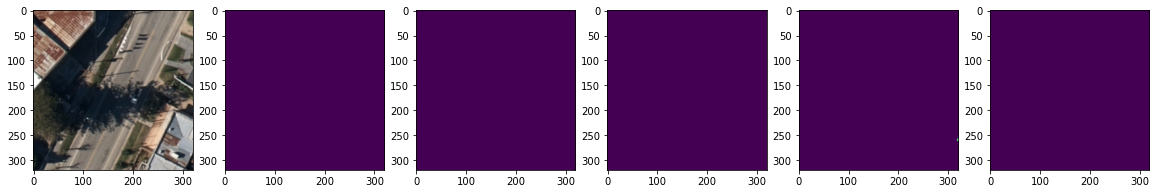

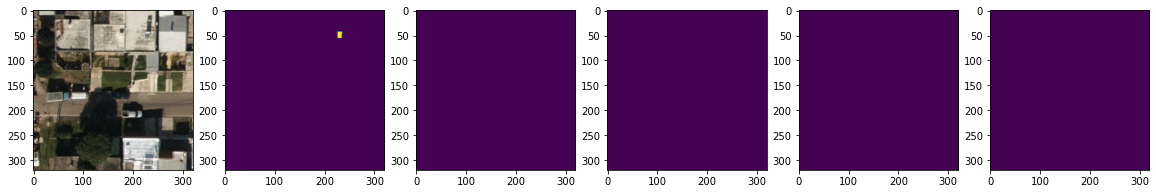

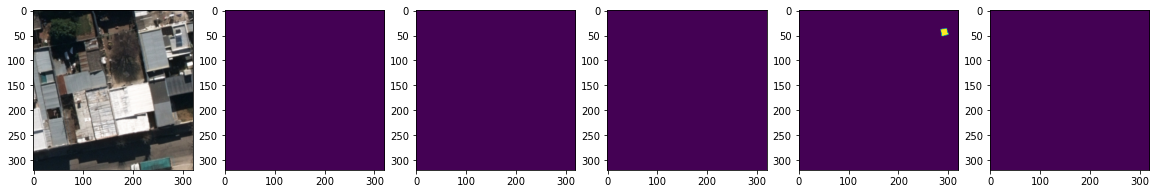

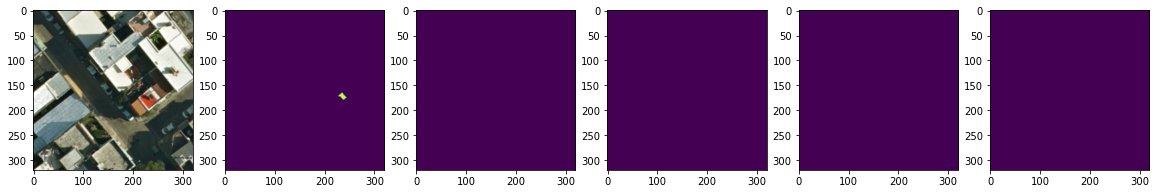

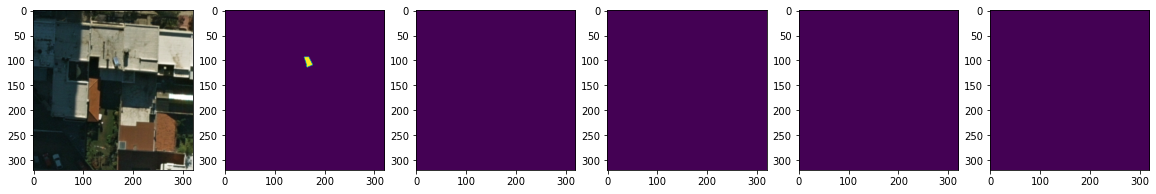

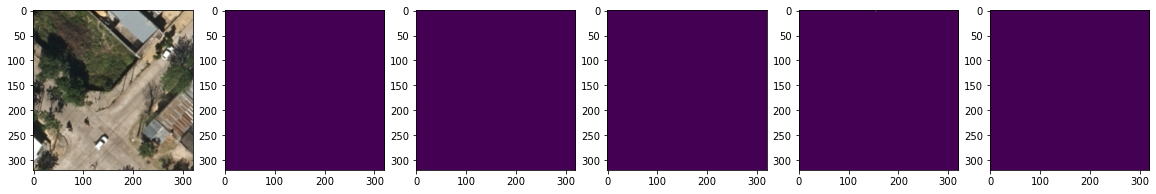

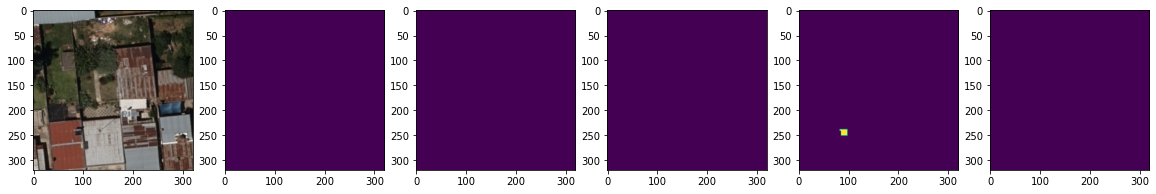

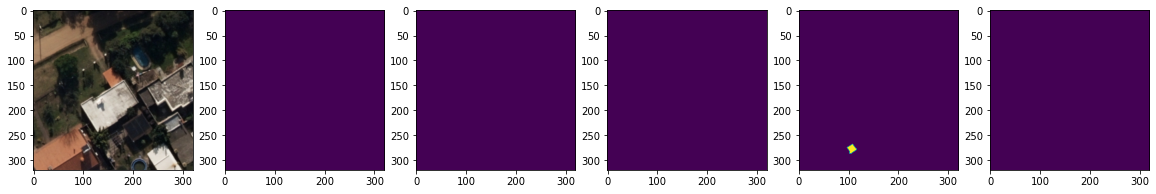

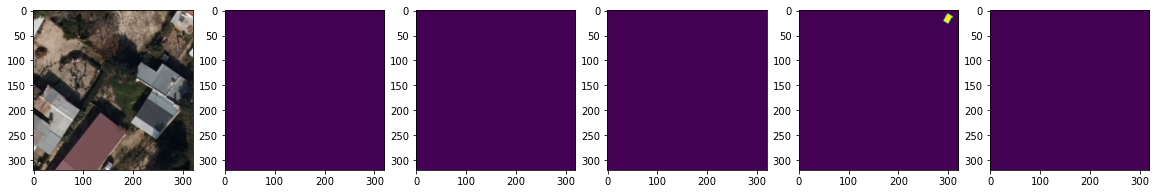

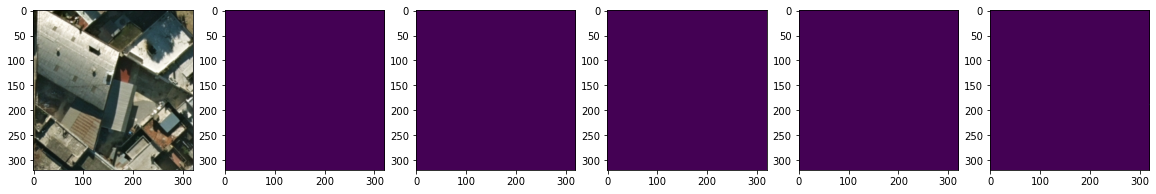

In [13]:
plot_data_generator(train_config=config, num_samples=10, fig_size=(20,10))

Ejecuta el entrenamiento

In [8]:
res = train(config)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 320, 320, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 320, 320, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

Epoch 1/30
200/200 [==============================] - 615s 3s/step - loss: 0.0357 - accuracy: 0.4334 - mean_iou: 0.4920 - val_loss: 0.0089 - val_accuracy: 0.0548 - val_mean_iou: 0.4991

Epoch 00001: val_loss improved from inf to 0.00890, saving model to data/colectores/weights/colectores_m1_v1.h5
Epoch 2/30
200/200 [==============================] - 546s 3s/step - loss: 0.0060 - accuracy: 0.3005 - mean_iou: 0.4994 - val_loss: 0.0054 - val_accuracy: 0.2435 - val_mean_iou: 0.4996

Epoch 00002: val_loss improved from 0.00890 to 0.00539, saving model to data/colectores/weights/colectores_m1_v1.h5
Epoch 3/30
200/200 [==============================] - 552s 3s/step - loss: 0.0046 - accuracy: 0.2919 - mean_iou: 0.4999 - val_loss: 0.0031 - val_accuracy: 0.5039 - val_mean_iou: 0.5004

Epoch 00003: val_loss improved from 0.00539 to 0.00310, saving model to data/colectores/weights/colectores_m1_v1.h5
Epoch 4/30
200/200 [==============================] - 549s 3s/step - loss: 0.0037 - accuracy: 0.52

Para cada epoch, se imprimen las siguientes métricas:
* `loss`: *pérdida* o error sobre el dataset de entrenamiento, en este caso es la *binary cross entropy*, muy utilizada para clasificadores. Ver [más información](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).
* `accuracy`: precisión, proporción de aciertos (TPs y TNs) sobre el total.
* `mean_iou`: promedio de la Intersección sobre Unión (IoU), métrica muy utilizada en problemas de segmentación semántica. También conocido como [índice de Jaccard](https://en.wikipedia.org/wiki/Jaccard_index).

Estas métricas se calculan primero sobre el datset de entrenamiento, y al terminar un epoch, se calculan sobre el dataset de validación (ver valores de las métricas cuyo nombre empieza con `val_`).

Podemos graficar algunas de estas métricas para visualizar mejor como el modelo fue mejorando. Lo importante es ver que el error converge a un valor y el error en validación no es mucho mayor que el de entrenamiento (van a la par). Si fuera mayor, se dice que el modelo sobreajusta (*overfitting*) y nos termina quedando un modelo que predice bien sobre el dataset de entrenamiento pero no sobre nuevos datos.

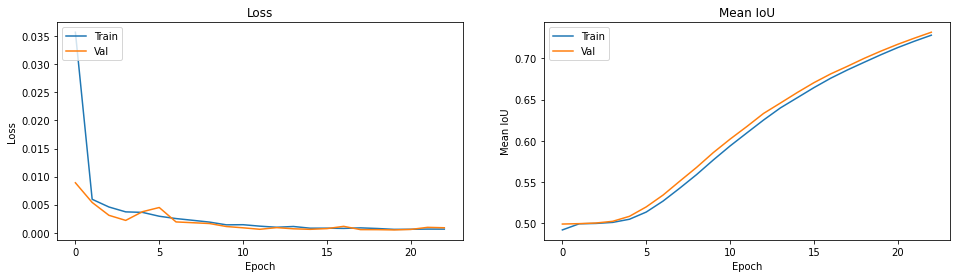

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res.history['mean_iou'])
plt.plot(res.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()